In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import time
import scipy.stats as sps
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

В данном проекте исследовалась компания по проведению дестких праздников в г. Санкт-Петербурге.
Целью исследования был краткий анализ таблиц данных с информацией по проведенным праздникам на всех площадках компании за временной промежуток 01.01.2021 - 31.03.2021
В качестве независимой переменной в первой части анализа выступала выручка с проведения праздников. Были получены ее зависимости от площадок проведения праздников и от дня недели.
Во второй части определены наиболее популярные праздничные тематики среди клиентов компании, а также вес в процентах каждой из категорий товаров, из которых формируется выручка компании.
Также был определен средний процент, который идет на выплату зарплат актерам и героям, участвующим в проведении торжества.
Полученные данные были представлены руководству компании.

In [48]:
df = pd.read_excel('chugik_01-03_2021_simple.xlsx')

### Цену приводим в float

In [50]:
df['Price'] = df['Price'].replace(r'\s+','',regex=True)

df['Price'] = pd.to_numeric(df['Price'])

### Суммарная выручка за январь - март

In [52]:
profit = df.groupby(df.Date.dt.month)['Price'] \
    .sum().sort_values(ascending=False).to_frame().round()
profit

,Price
Date,
3,6093173.0
2,4944146.0
1,4044466.0


In [53]:
profit.sum()

Price    15081785.0
dtype: float64

### Группируем по выручке по площадкам. Убираем Онлайн.

In [54]:
df = df[df['Place'] != 'Онлайн']

In [55]:
df_sum_Place = df.groupby('Place')['Price'].sum().sort_values(ascending=False).to_frame()

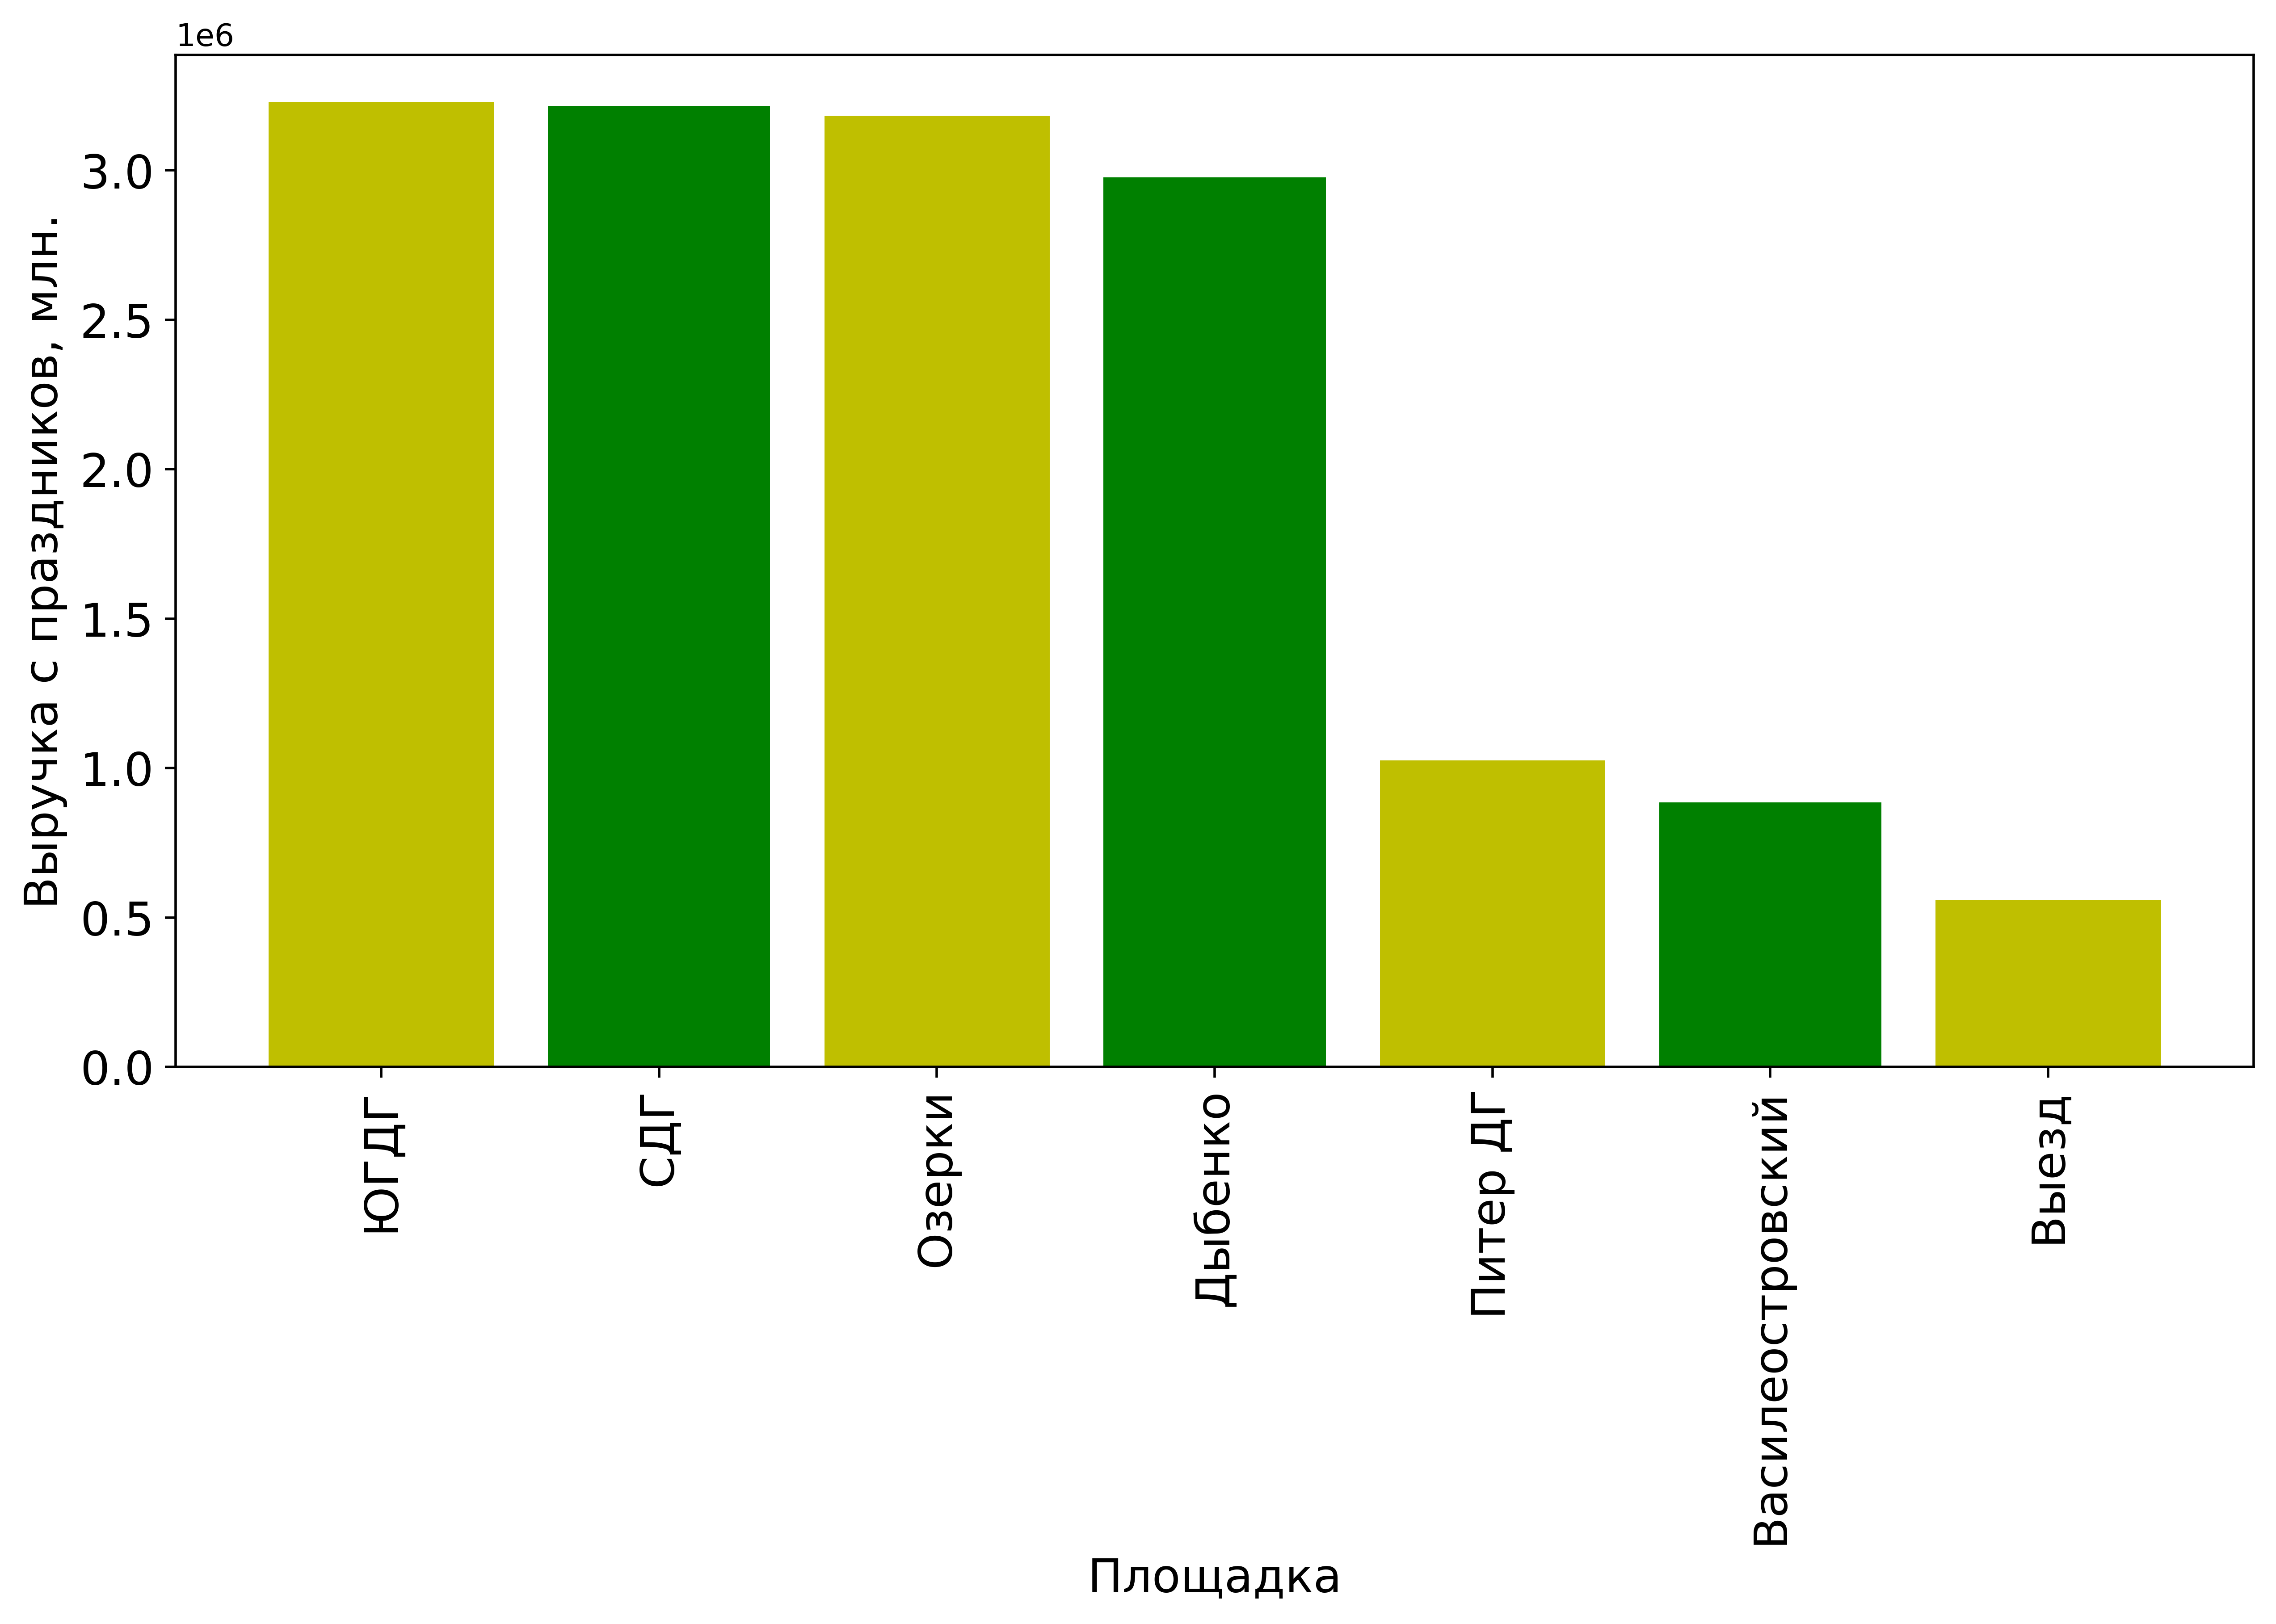

In [345]:
plt.figure(figsize=(12,6), dpi=500)
for_color = plt.bar(df_sum_Place.index, df_sum_Place['Price'], color='g')
for n in range(0,7,2):
    for_color[n].set_color('y')
plt.ylabel('Выручка с праздников, млн.', size=15)
plt.xlabel('Площадка', size=15)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.show()

### Группируем по средней стоимости праздника по площадкам

In [57]:
df_perHoliday_Place = df.groupby('Place')['Price'].mean() \
    .sort_values(ascending=False).to_frame().round()

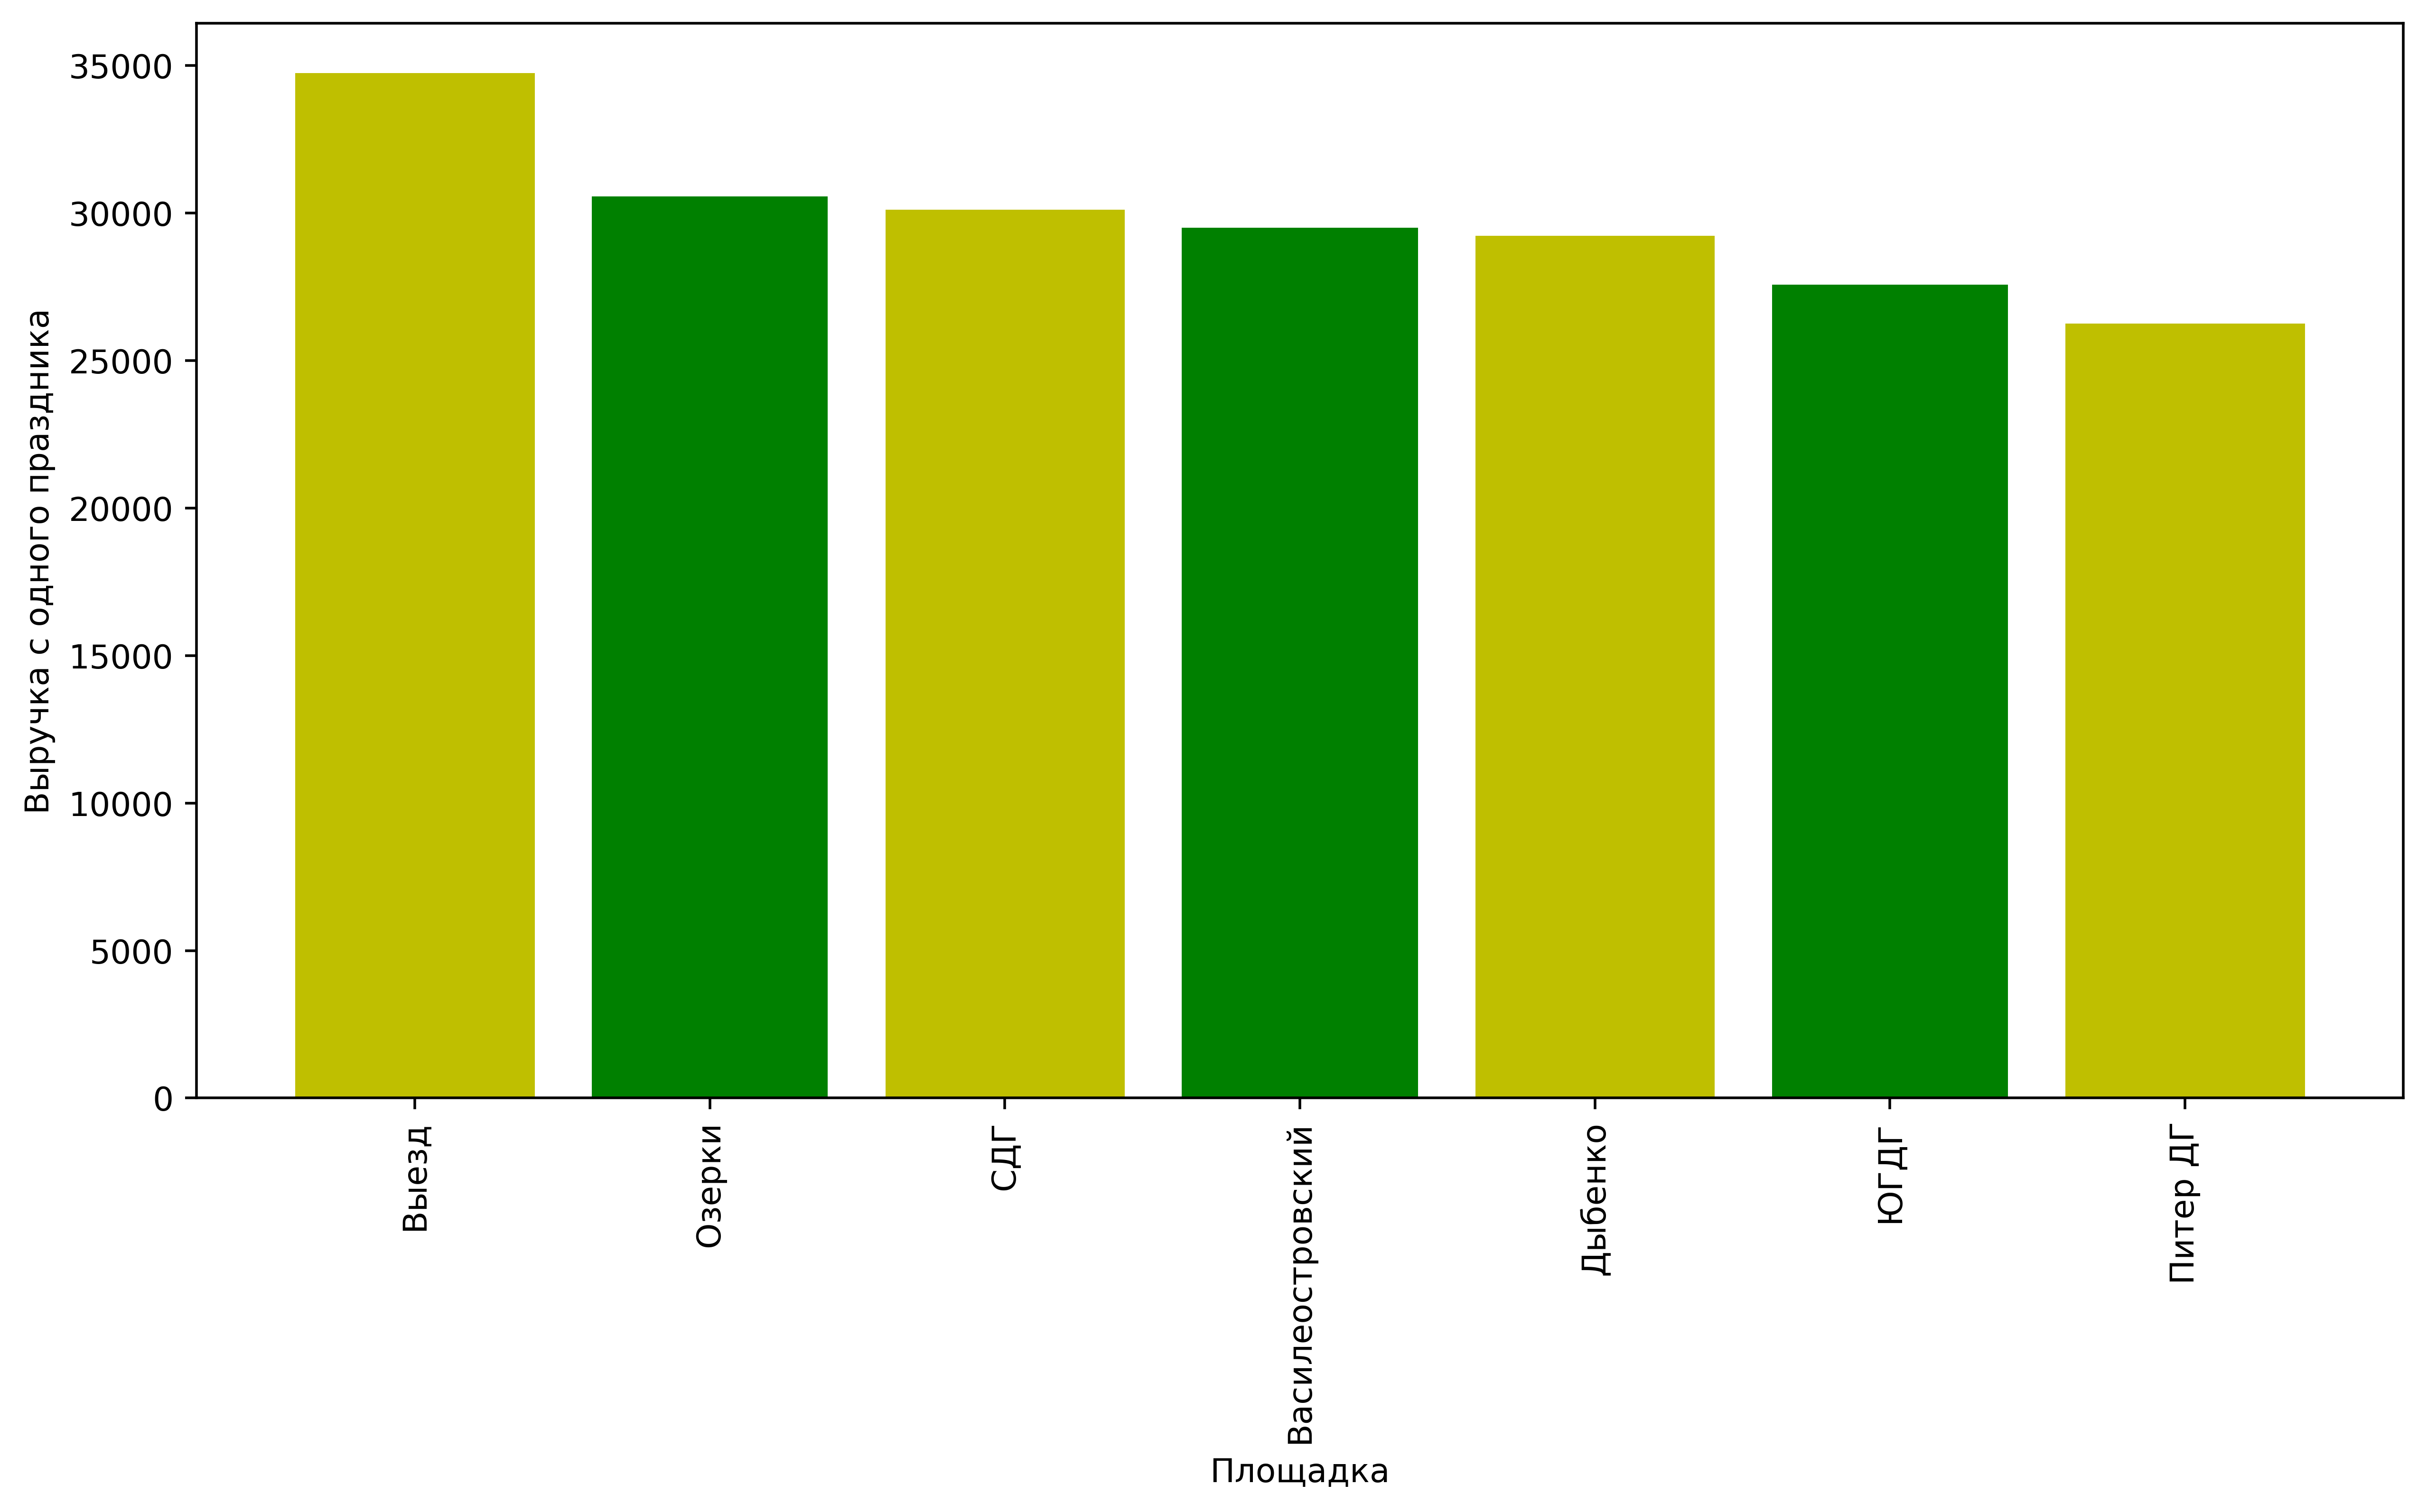

In [58]:
plt.figure(figsize=(12,6), dpi=500)
for_color = plt.bar(df_perHoliday_Place.index, df_perHoliday_Place['Price'], color='g')
for n in range(0,7,2):
    for_color[n].set_color('y')
plt.ylabel('Выручка с одного праздника')
plt.xlabel('Площадка')
plt.xticks(rotation='vertical', size=10)
plt.show()

### Добавляем столбец Time, убираем лишние данные из Name

In [59]:
df['Time'] = df.Name.apply(lambda x: x.split(' ')[1]).to_frame()

In [60]:
df.Name = df.Name.apply(lambda x: x.split('//')[1])

#### Гистограмма занятности площадок по дням недели и времени

In [61]:
df.sort_values('Time', ascending=True)['Time'].unique();

In [62]:
df_SDG = df[df['Place'] == 'СДГ'].groupby('Date')['Time'].count().to_frame()

In [63]:
def time_gap(x):
    gap = x.split('-')
    d = datetime.datetime.strptime(gap[0], '%H:%M')
    dd = ''
    while str(dd) != gap[1]:
        d += datetime.timedelta(minutes=30)
        minute = ('00' if str(d.minute) == '0' else '30')
        dd = f'{d.hour}:{minute}'
        if dd != gap[1]:
            gap.append(dd)
    gap.sort()
    return gap

In [64]:
df['Hours'] = df['Time'].apply(lambda x: time_gap(x))

In [65]:
df['Weekday'] = df['Date'].dt.weekday
df['Day_name'] = df['Date'].dt.day_name()

In [66]:
df_Hours_inPlace_SDG = df[df['Place'] == 'СДГ'].groupby(['Place', 'Weekday'], as_index=False) \
    .agg({'Hours': 'sum', 'Name': 'count', 'Day_name': 'max'}). \
    rename(columns={'Name': 'Amount_of_holidays'})

In [67]:
df_Hours_inPlace_SDG;

In [68]:
time_df = pd.DataFrame(columns=['12:00', '12:30',
                  '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
                  '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
                  '21:00', '21:30'])
time_dict = {}
for day in range(0,7):
    time = df_Hours_inPlace_SDG.iloc[day, 2]
    check_time = ['12:00', '12:30',
                  '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
                  '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
                  '21:00', '21:30']
    for check in check_time:
        time_dict[check] = time.count(check)
    time_df = time_df.append(time_dict, ignore_index=True)
        

### Расчет: Количество праздников в каждые полчаса --- СДГ, январь-март

In [69]:
df_SDG_time = df_Hours_inPlace_SDG['Day_name'].to_frame().join(time_df)

In [70]:
X = [np.arange(12.03, 21.53, 0.5, dtype='float')] * 7
for i in range(0,7):
    X[i] = X[i] + 0.06*i

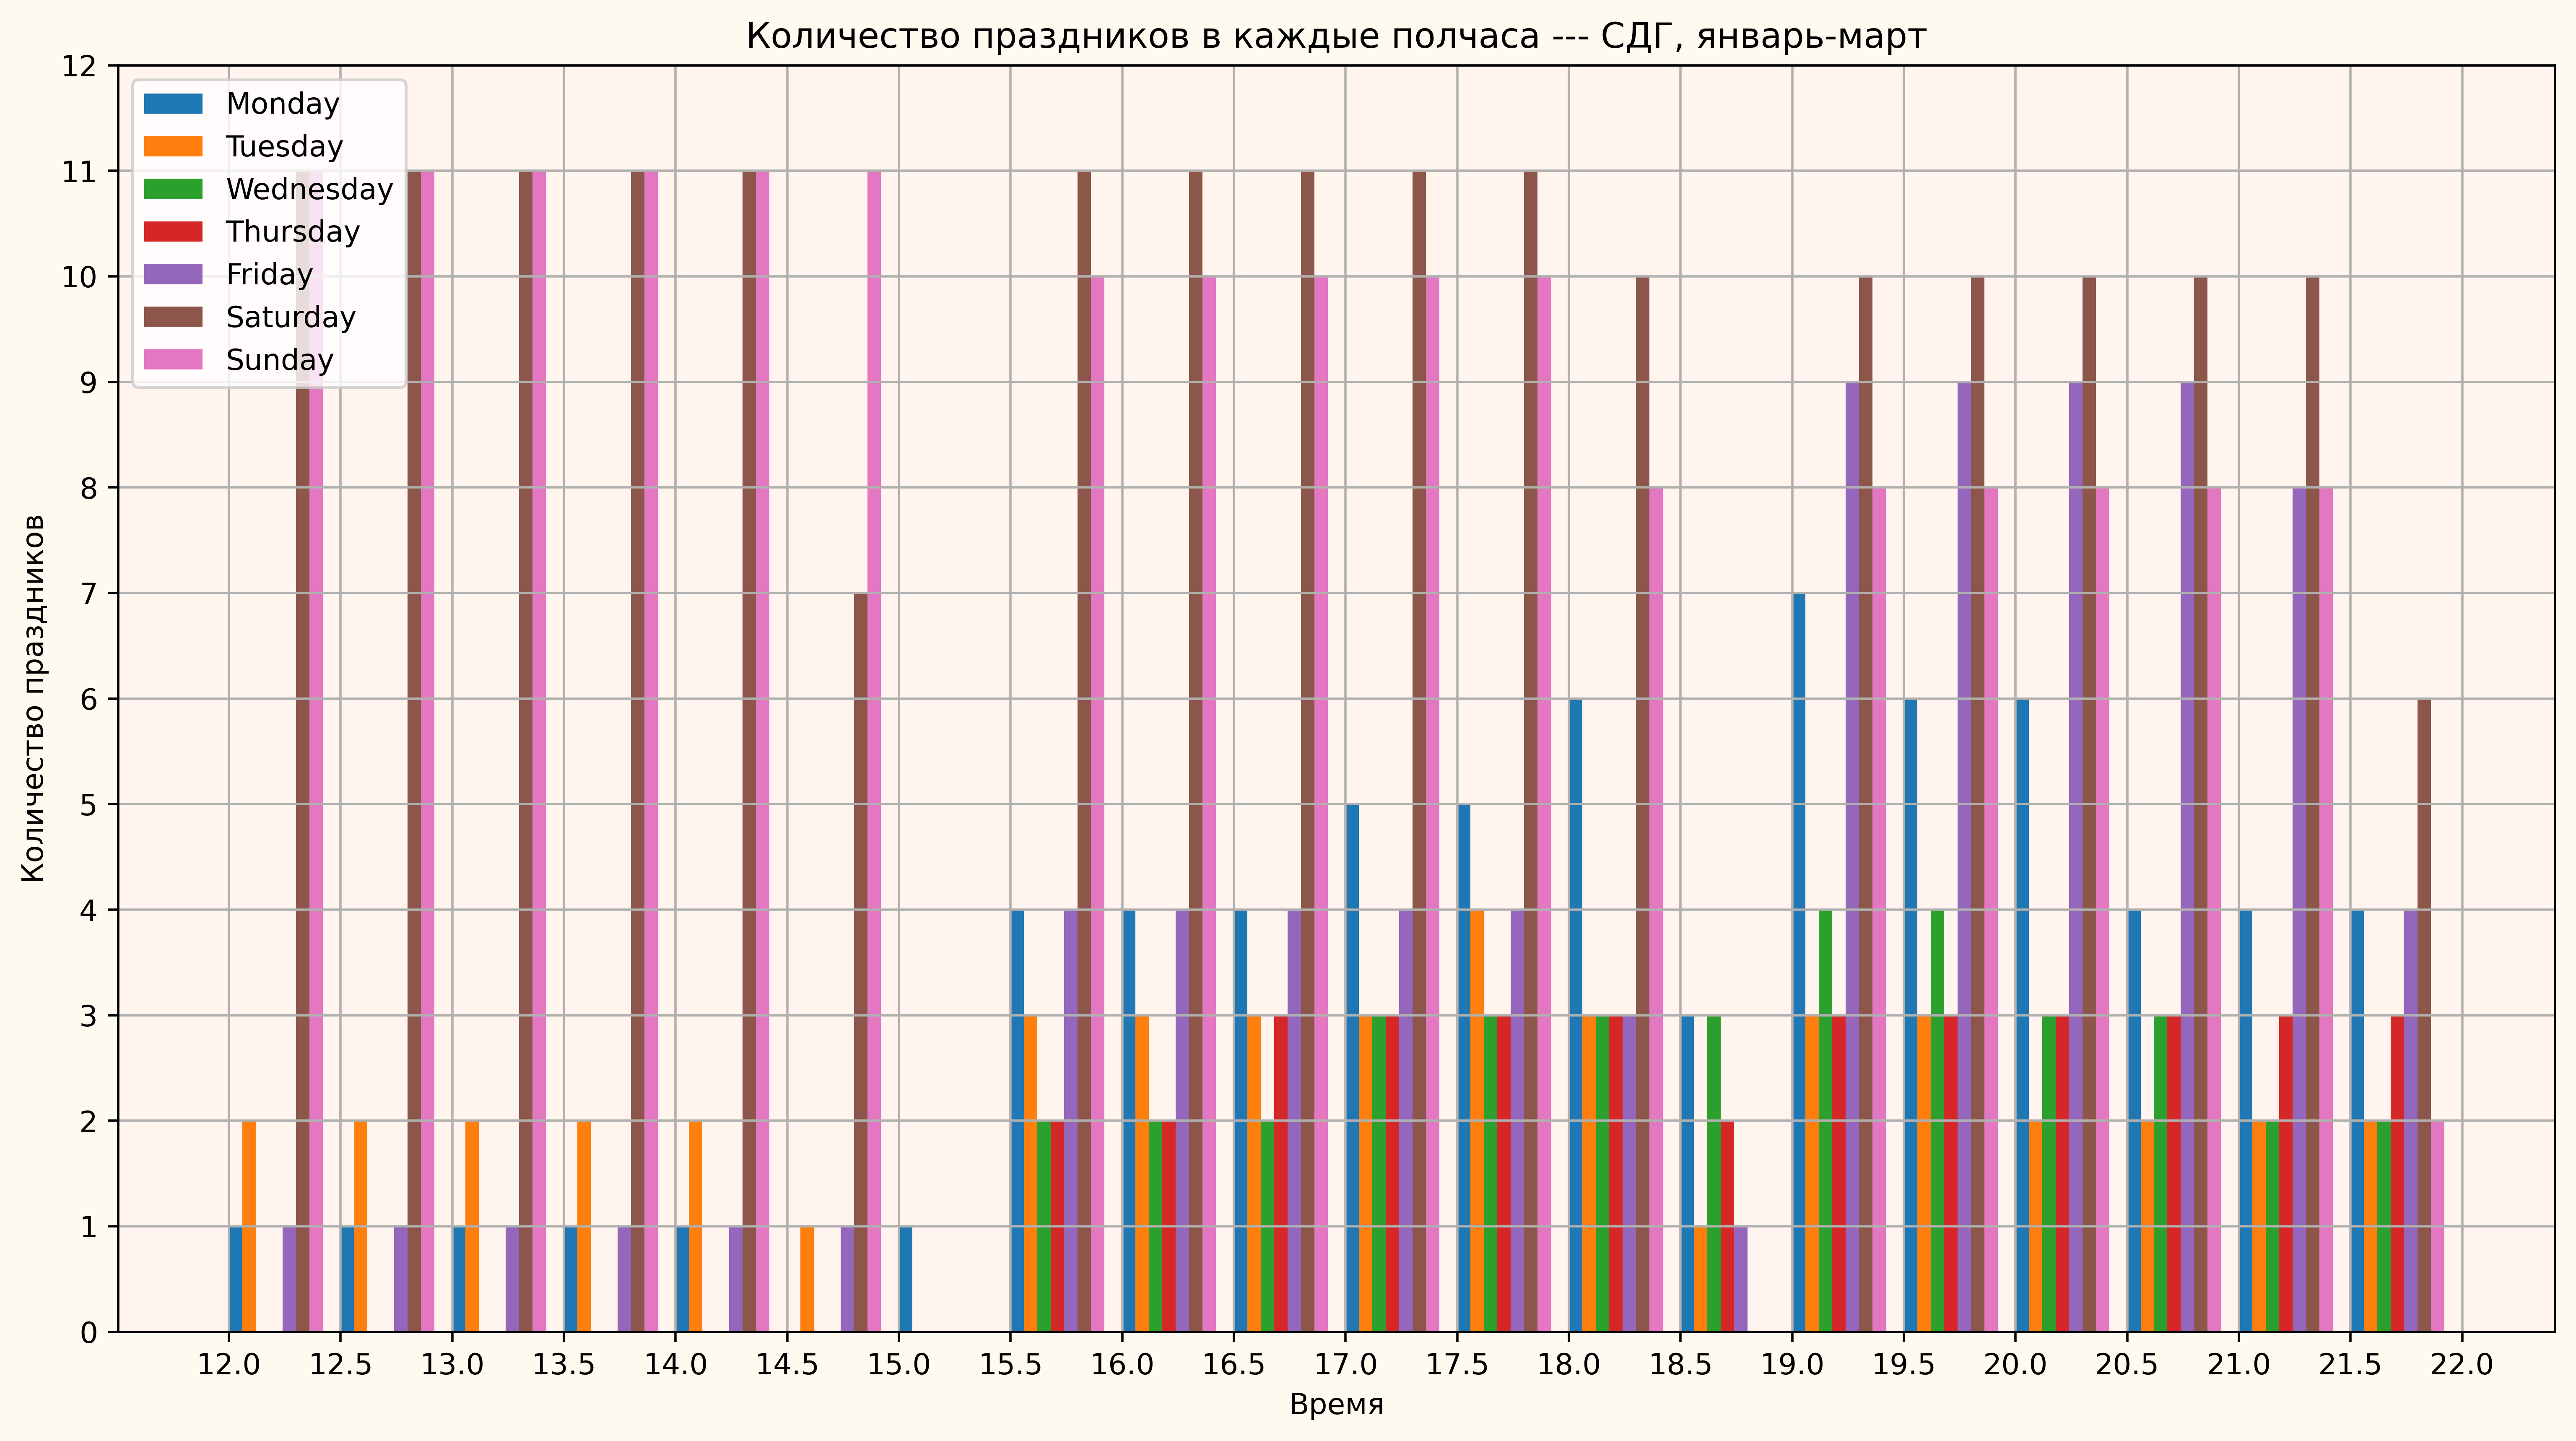

In [71]:
fig, ax = plt.subplots(dpi=500)

for i in range(0,7):
    x = X[i]
    y = df_SDG_time.drop(['Day_name'], axis=1).iloc[i,:]
    ax.bar(x, y, width=0.06, label=df_SDG_time.Day_name[i])

ax.set_facecolor('seashell')
fig.set_figwidth(15)
fig.set_figheight(8)
fig.set_facecolor('floralwhite')

plt.xticks(np.arange(12,22.5,0.5))
plt.yticks(np.arange(0,13))
plt.legend(loc=2)
plt.title('Количество праздников в каждые полчаса --- СДГ, январь-март')
plt.xlabel('Время')
plt.ylabel('Количество праздников')
plt.grid()
plt.show()

### Аналогично по будням

In [72]:
time_df = pd.DataFrame(columns=['12:00', '12:30',
                  '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
                  '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
                  '21:00', '21:30'])
time_dict = {}
for day in range(0,5):
    time = df_Hours_inPlace_SDG.iloc[day, 2]
    check_time = ['12:00', '12:30',
                  '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
                  '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
                  '21:00', '21:30']
    for check in check_time:
        if day == 0:
            time_dict[check] = round(time.count(check) / 0.63, 2)
        else:
            time_dict[check] = time_dict[check] + round(time.count(check) / 0.63, 2)

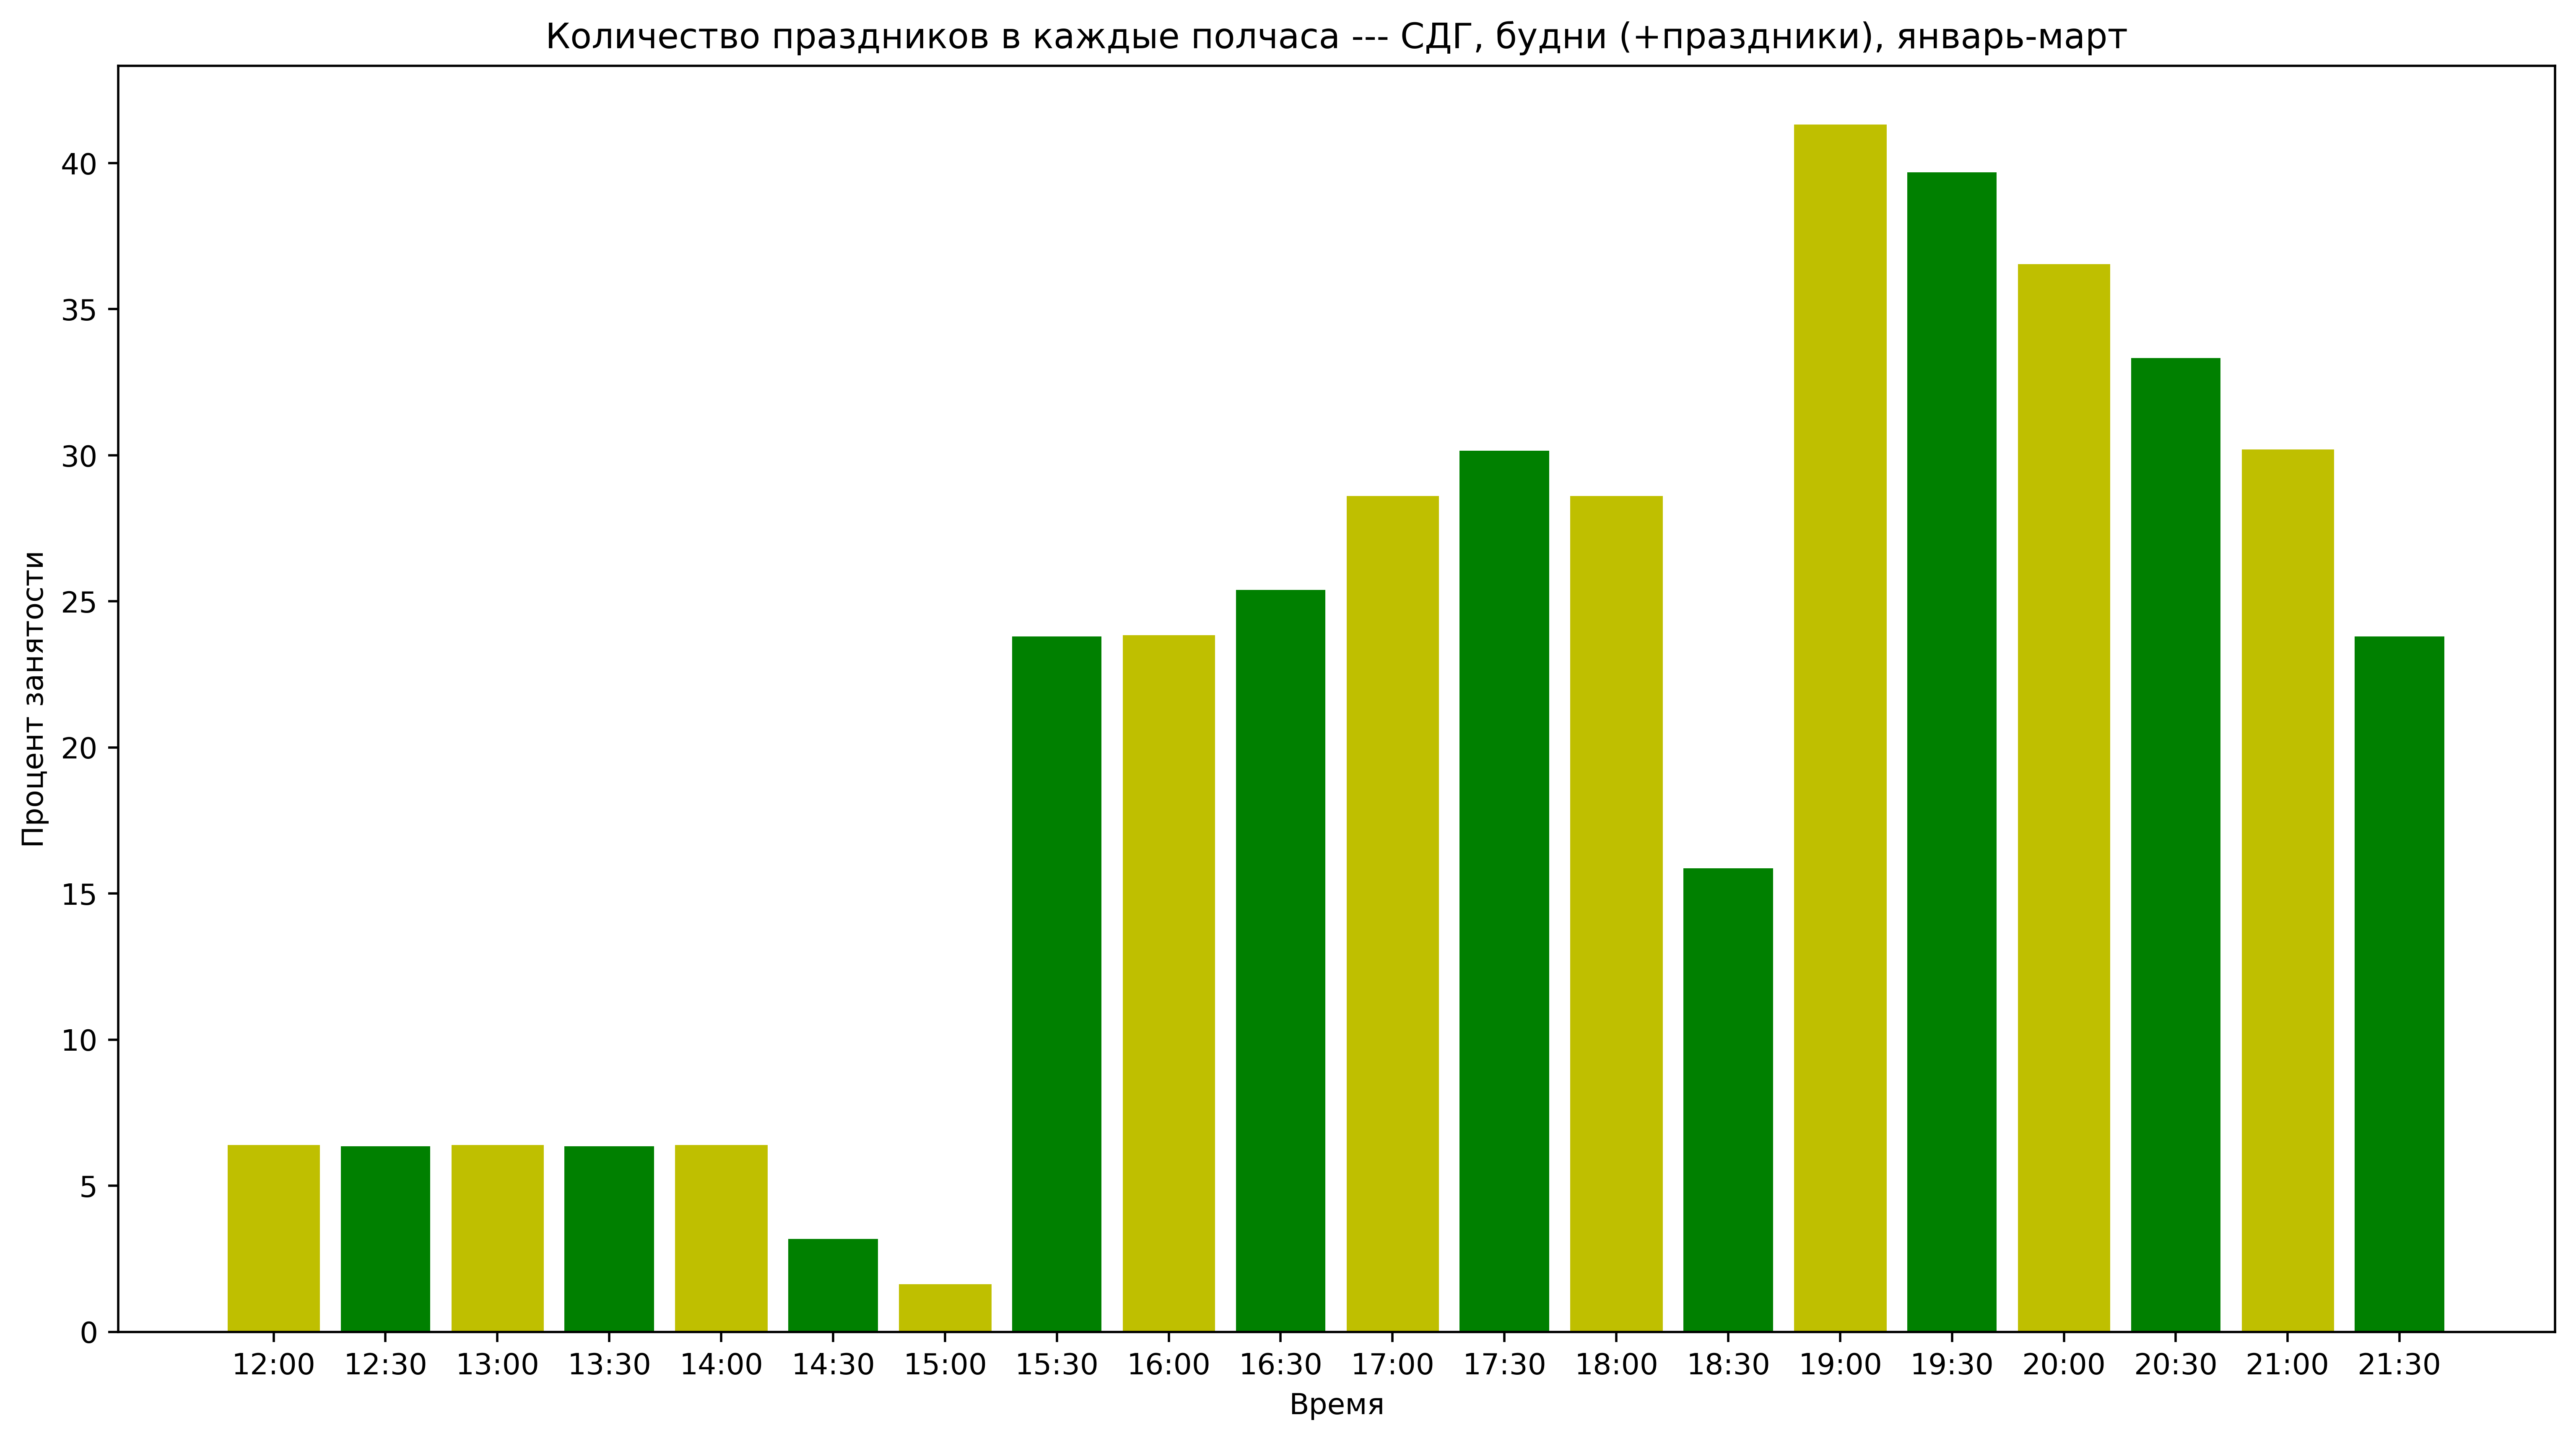

In [73]:
fig, ax = plt.subplots(dpi=500)

x = time_dict.keys()
y = time_dict.values()
for_color = ax.bar(x, y, color='g')
for n in range(0,len(check_time),2):
    for_color[n].set_color('y')

fig.set_figwidth(15)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure

plt.title('Количество праздников в каждые полчаса --- СДГ, будни (+праздники), январь-март')
plt.xlabel('Время')
plt.ylabel('Процент занятости')
plt.show()

### Популярность программ

In [74]:
programs_list = ['Майнкрафт', 'Гравити Фолз', 'Форт Боярд', 'Тайны Египта Джуниор',
           'Фактор Страха', 'Гарри Поттер', 'Шерлок Холмс', 'Джокер',
           'Холодное сердце', 'Тайны Египта', 'Волшебная вечеринка']

programs = dict.fromkeys(['Майнкрафт', 'Гравити Фолз', 'Форт Боярд', 'Тайны Египта Джуниор',
           'Фактор Страха', 'Гарри Поттер', 'Шерлок Холмс', 'Джокер',
           'Холодное сердце', 'Тайны Египта', 'Волшебная вечеринка'], 0)

def take_prog(x):
    a = 0
    for j in range(len(programs_list)):
        if programs_list[j] in x:
            programs[programs_list[j]] += 1
            a = 1
    if a == 0:
        raise NameError('Some programs are not defined. CHEEECK IT!')
    return

In [75]:
df['Name'].apply(lambda x: take_prog(x))
programs['Тайны Египта'] = programs['Тайны Египта'] - programs['Тайны Египта Джуниор']

In [76]:
list_prog = list(programs.items())
list_prog.sort(key=lambda x: x[1], reverse=True)
y_axis, x_axis = [], []
for i in range(len(list_prog)):
    y_axis.append(list_prog[i][1])
    x_axis.append(list_prog[i][0])

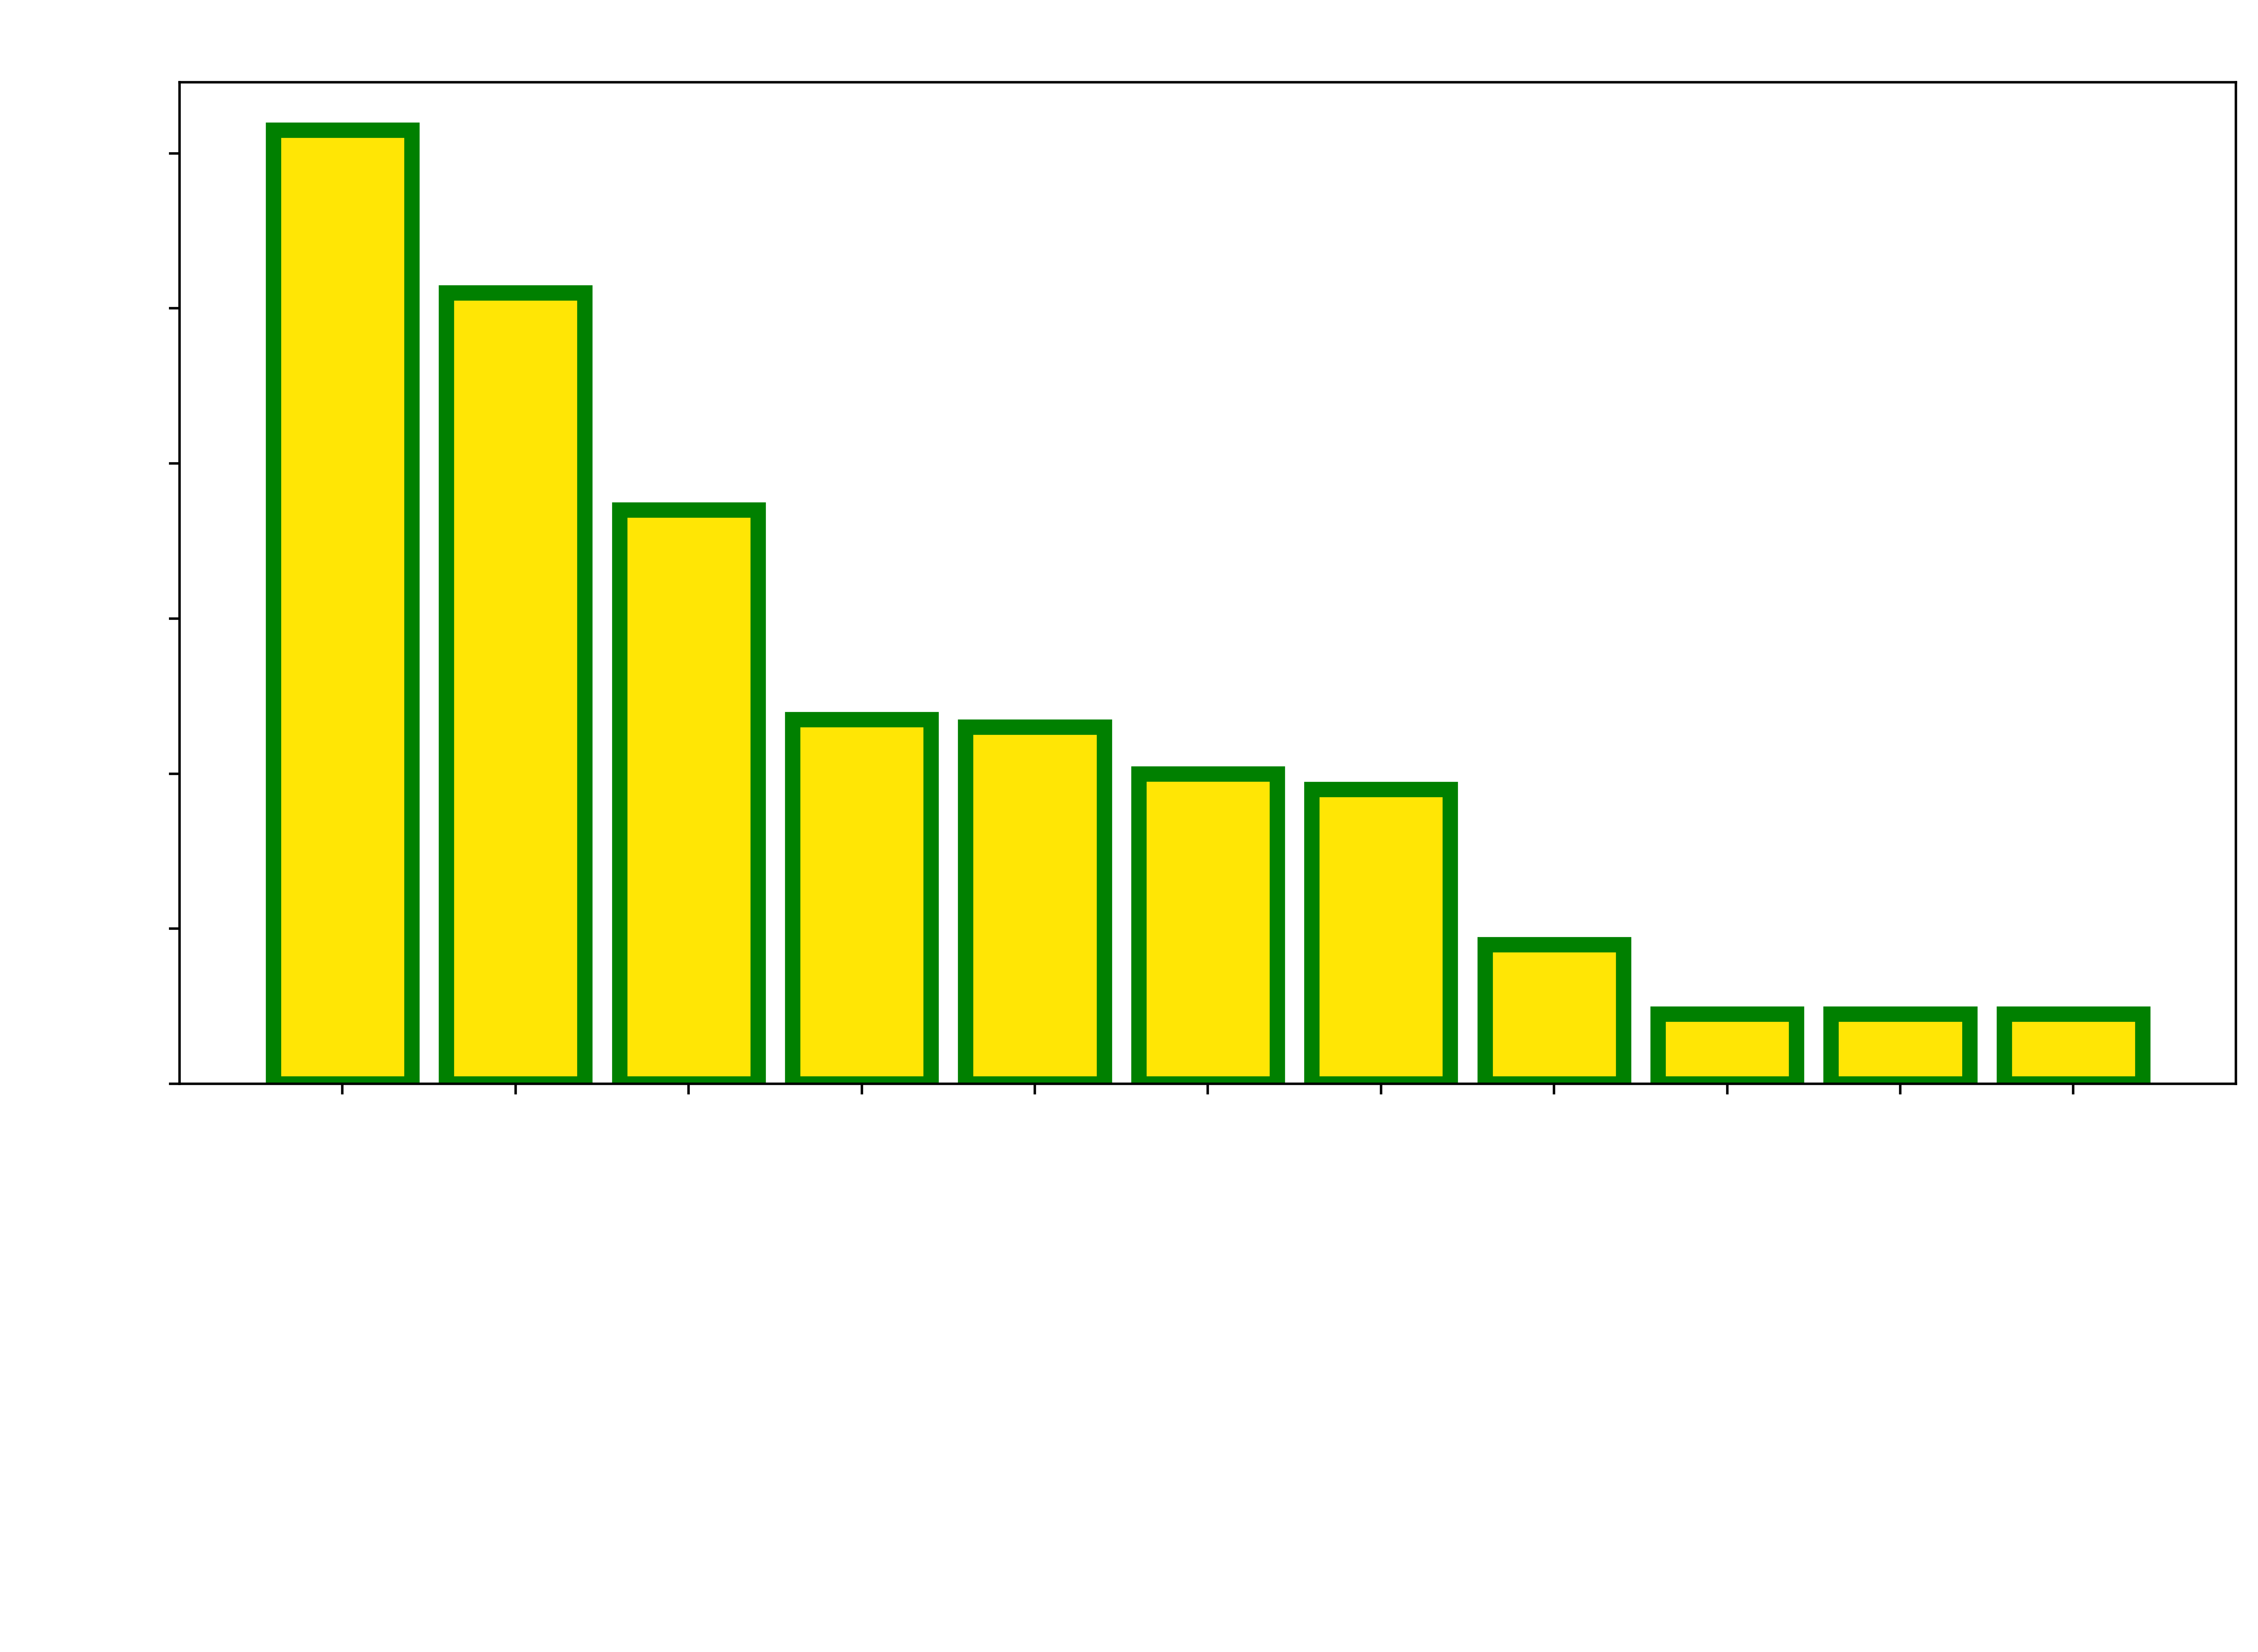

In [77]:
plt.figure(figsize=(12,6), dpi=500)
for_color = plt.bar(x_axis, y_axis, color=(1, 0.9, 0.02), linewidth=5, edgecolor='g')
plt.title('Количество праздников по тематикам --- январь-март', color='w', size=18)
plt.ylabel('Количество праздников', color='w', size=18)
plt.xlabel('Тематика праздника', color='w', size=18)
plt.xticks(rotation='vertical', size=12, color='w')
plt.yticks(color='w', size=12)
plt.show()

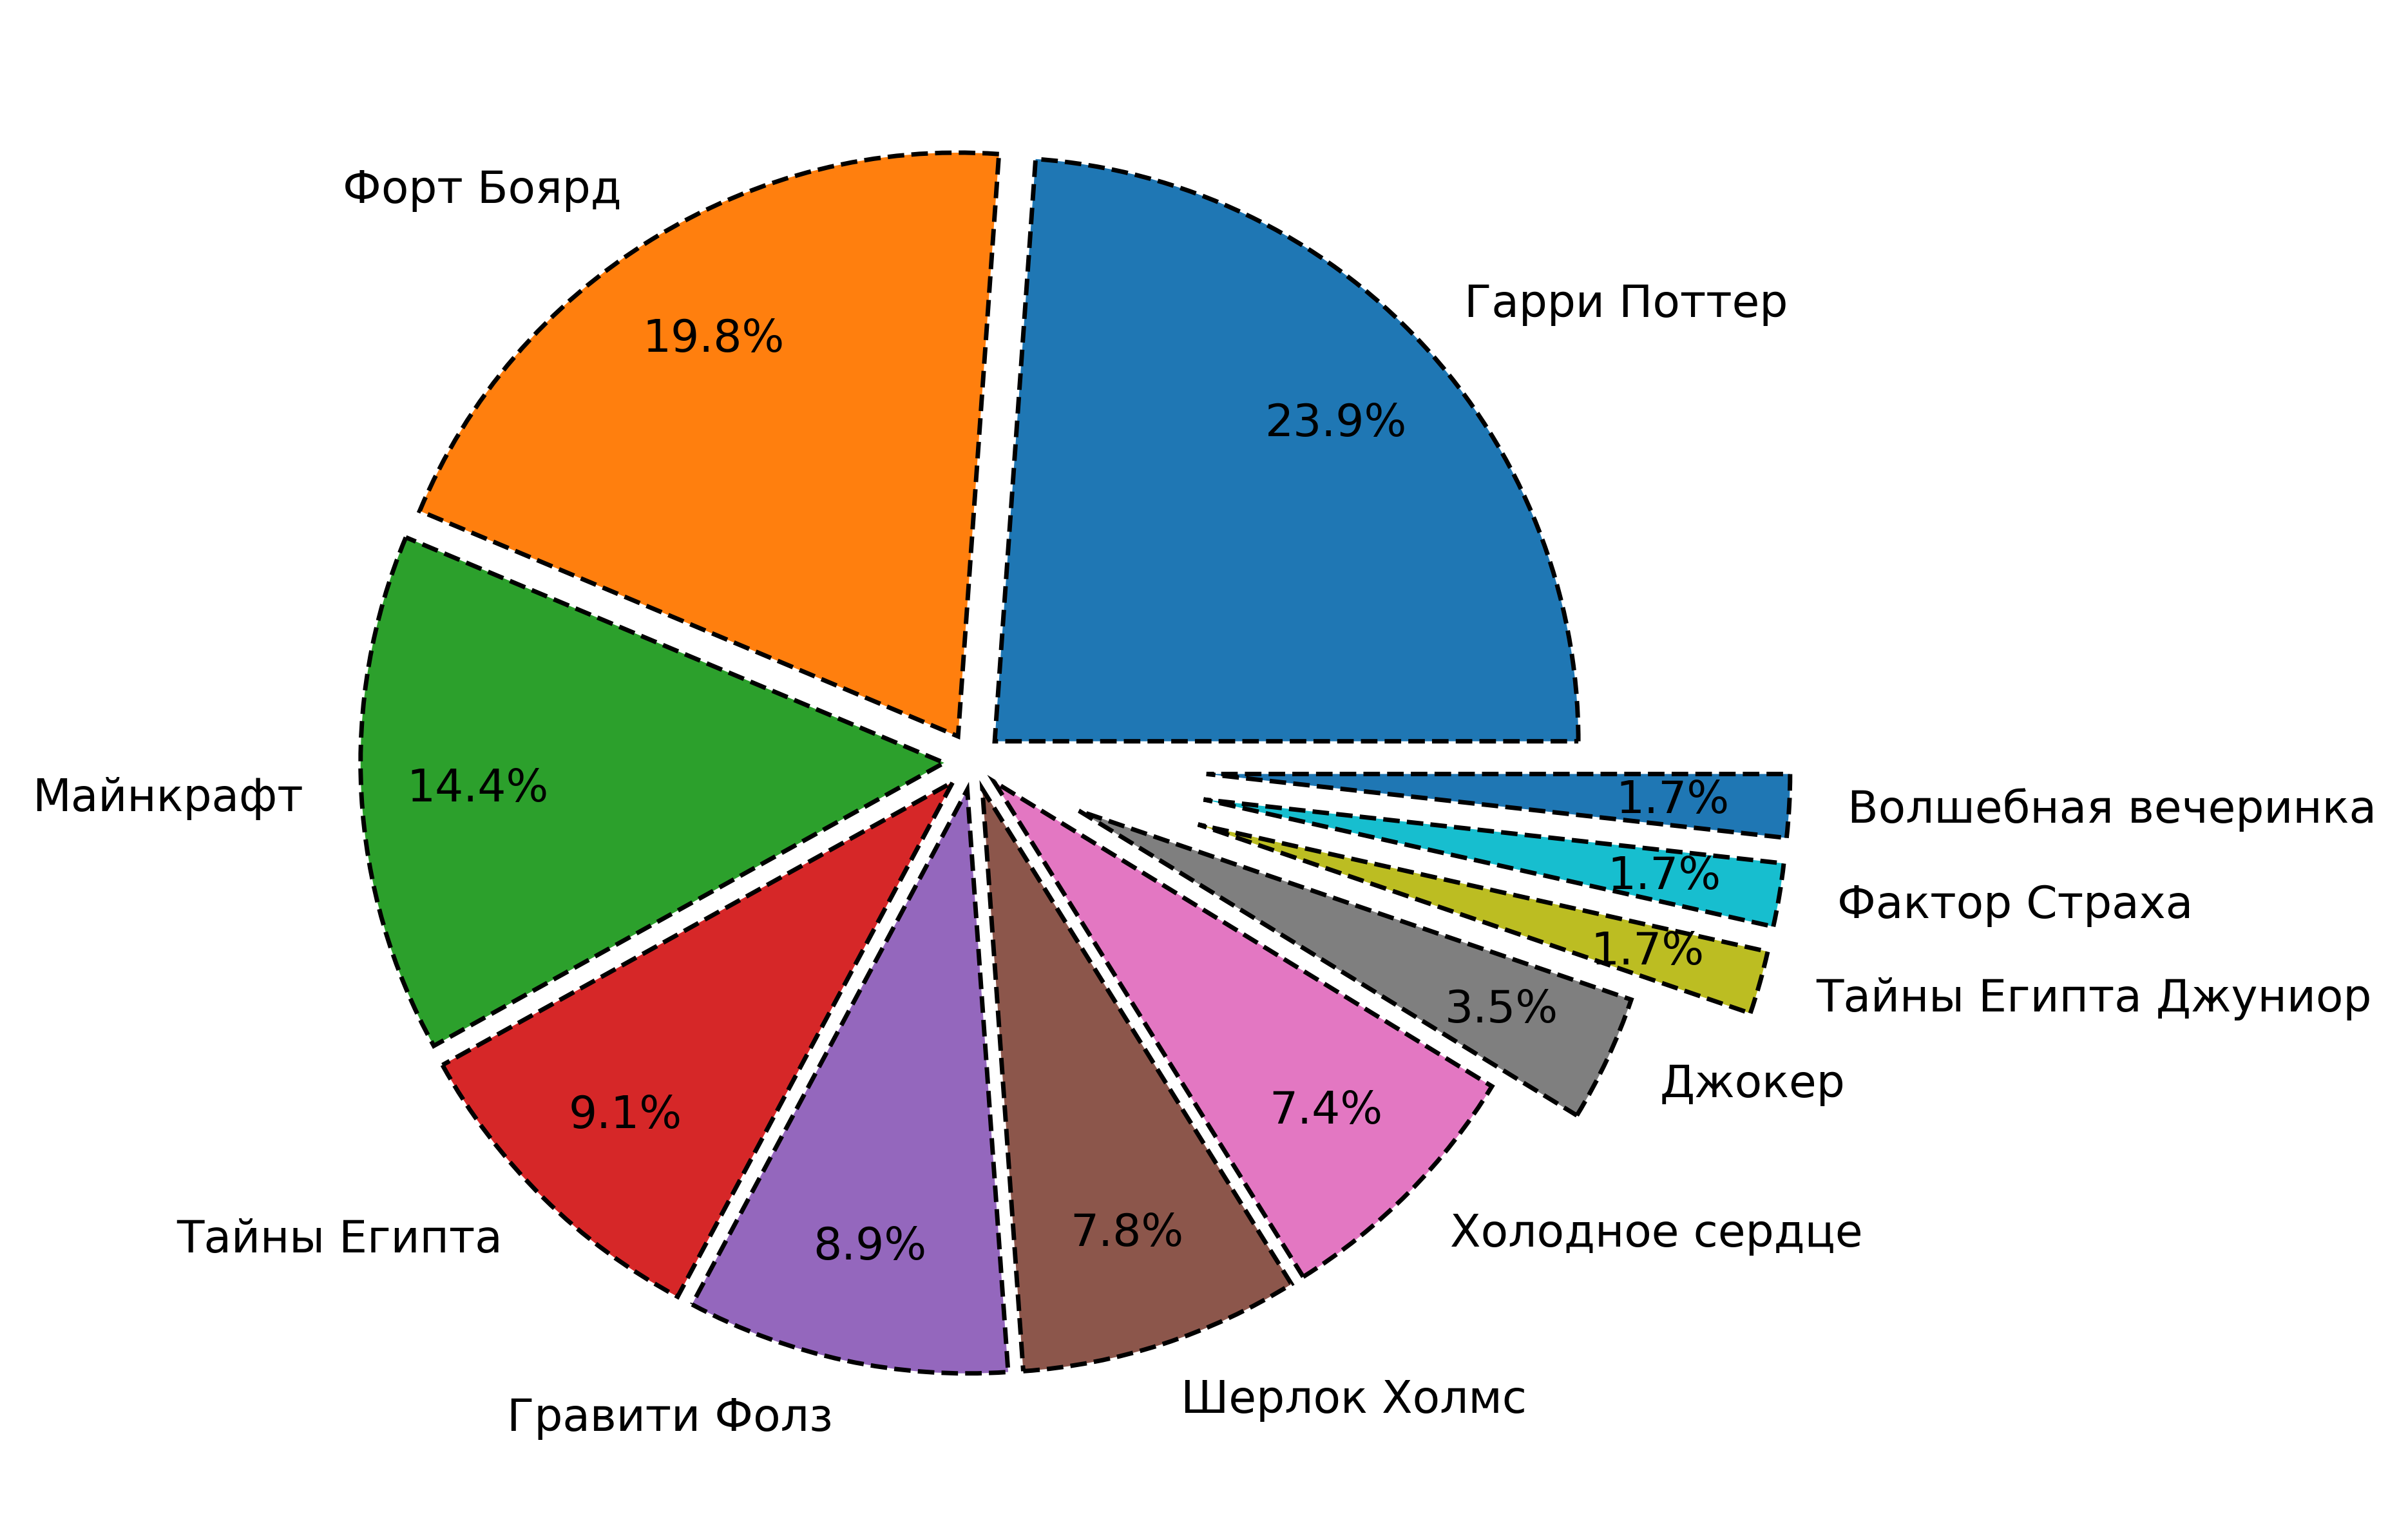

In [78]:
plt.figure(figsize=(12,6), dpi=500)
exp = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.2, 0.4, 0.4, 0.4)
plt.pie(y_axis, labels=x_axis, autopct='%1.1f%%', explode=exp, pctdistance=0.8,
       wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"})
plt.show()

### Расширенные данные

In [79]:
full = pd.read_excel('chugik_01-03_2021_full.xlsx')

### Избавляемся от дат в quantity и создаем df с данными по product

In [80]:
for i in range(len(full)):
    if (type(full.loc[i, 'Product_quantity']) != int) & \
    (type(full.loc[i, 'Product_quantity']) != str):
        full.loc[i, 'Product_quantity'] = 1

In [81]:
new = full
new['Product_sum'] = new['Product_sum'].replace(r'\s+','',regex=True)

prod = pd.DataFrame(columns=['Product', 'Quantity', 'Cost'])

for index, value in new.Product_name.str.lower().to_frame().iterrows():
    for row in value:
        quantity = float(new.iloc[index, 8])
        cost = float(new.iloc[index, 9])
        prod.loc[len(prod)] = [row, quantity, cost]


In [82]:
prod_profit = prod.groupby('Product').agg({'Quantity': 'sum', 'Cost': 'sum'}) \
    .sort_values('Cost', ascending=False).reset_index()

### Объедиянем продукты по категориям

In [83]:
prod_profit_c = prod_profit.copy()
prod_profit_new = pd.DataFrame(columns=['Product', 'Quantity', 'Cost'])

### Актуальный вариант

In [84]:
prod_profit_copy = prod_profit.copy()

In [85]:
drinks = ['кофе', 'чай', 'капучино', 'латте', 'американо']
main = ['квест', 'класс', 'дискотека', 'тесла', 'мафия', 'викторина', 'игры', 'фокус',
        'шоу', 'пати', 'онлайн']
rent = ['аренд']
food = ['кейтеринг', 'торт', 'фонтан', 'официант']
features = ['свечи', 'посуда', 'посуды', 'фейер', 'шар', 'welcome', 'пиньята', 
            'слаймы', 'фейр', 'спецэф']
suvs = ['сувен']
photo = ['фото', 'съемка']
transport = ['транспорт']
other = ['доп', 'неуст', 'скидка']

for i in range(len(prod_profit_copy)):
    check = prod_profit_copy.iloc[i,0]
    for ii in range(len(drinks)):
        if drinks[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Напитки'
    for ii in range(len(main)):
        if main[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Праздник'
    for ii in range(len(rent)):
        if rent[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Аренда'
    for ii in range(len(food)):
        if food[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Угощения'
    for ii in range(len(features)):
        if features[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Атмосфера'
    for ii in range(len(suvs)):
        if suvs[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Сувениры'
    for ii in range(len(photo)):
        if photo[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Съемка'
    for ii in range(len(transport)):
        if transport[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Транспорт'
    for ii in range(len(other)):
        if other[ii] in check:
            prod_profit_copy.iloc[i,0] = 'Остальное'
            

In [86]:
prod_profit_copy = prod_profit_copy.groupby('Product') \
    .agg({'Quantity': 'sum', 'Cost': 'sum'}).sort_values('Cost', ascending=False) \
    .reset_index()

### Строим круговую по всем категориям

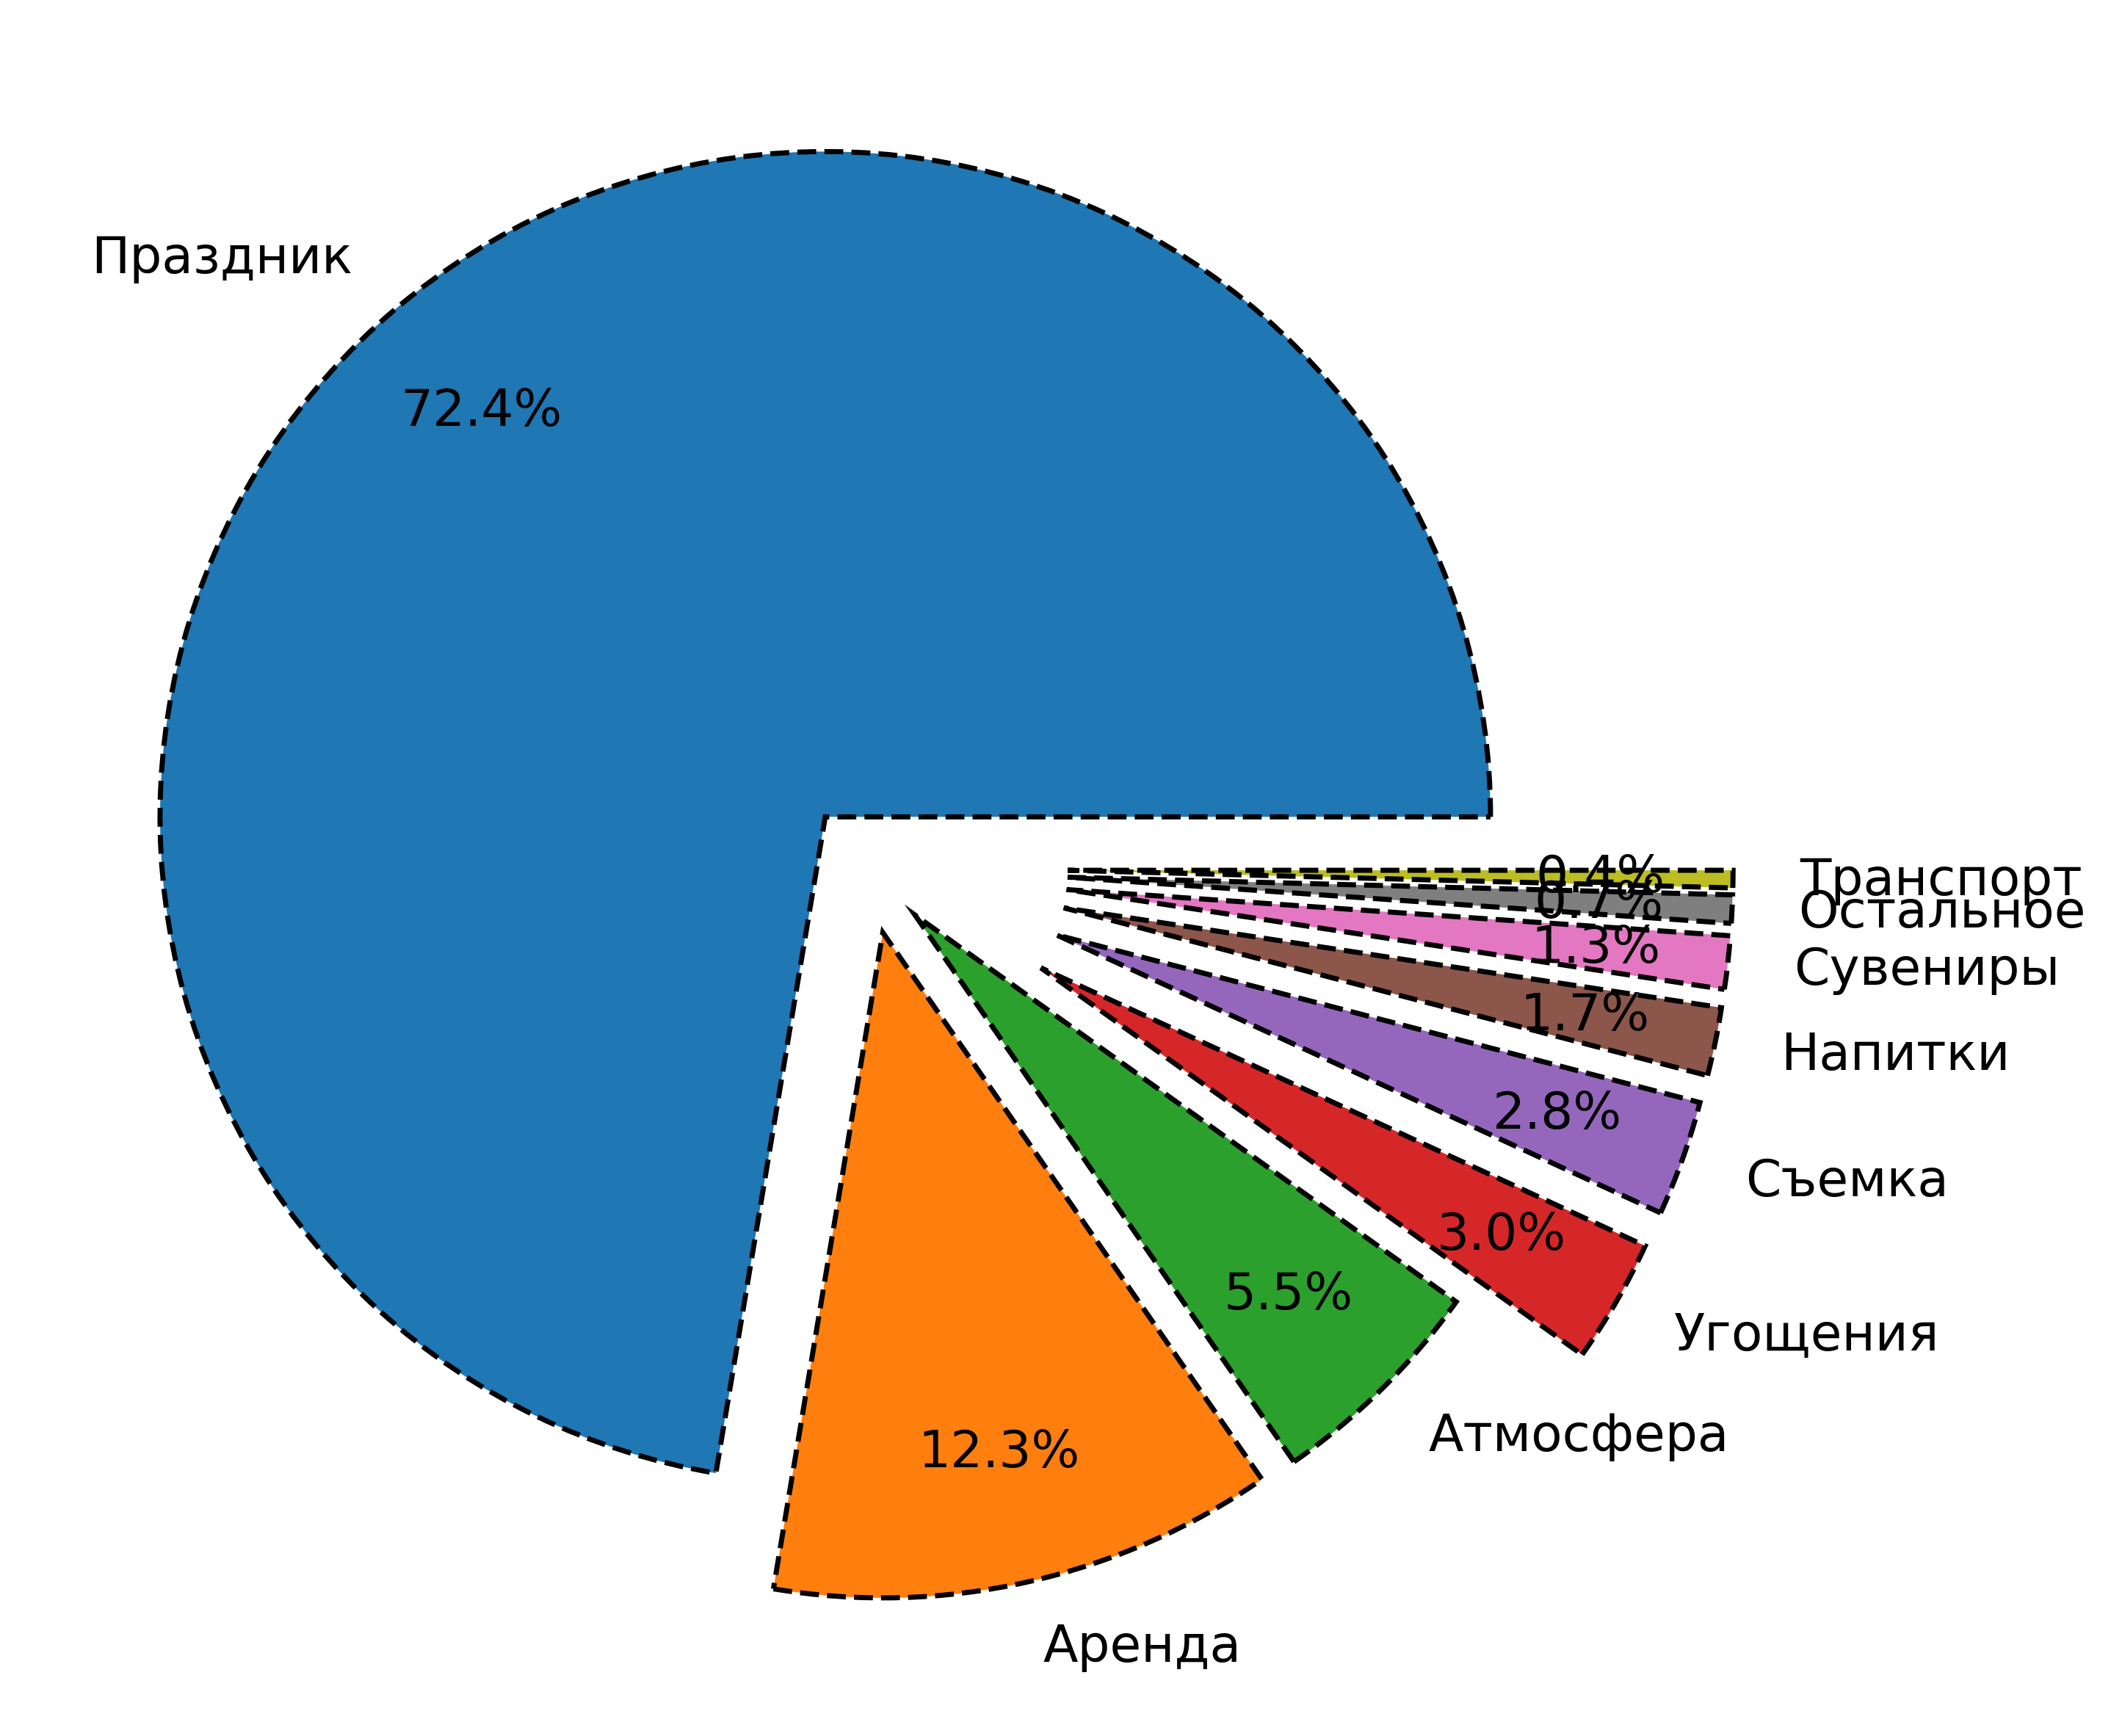

In [87]:
plt.figure(figsize=(12,6), dpi=500)
exp = (0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3)
plt.pie(prod_profit_copy.Cost, labels=prod_profit_copy.Product, autopct='%1.1f%%', 
        explode=exp, pctdistance=0.8, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"})
plt.show()

### Круговая без "Праздник"

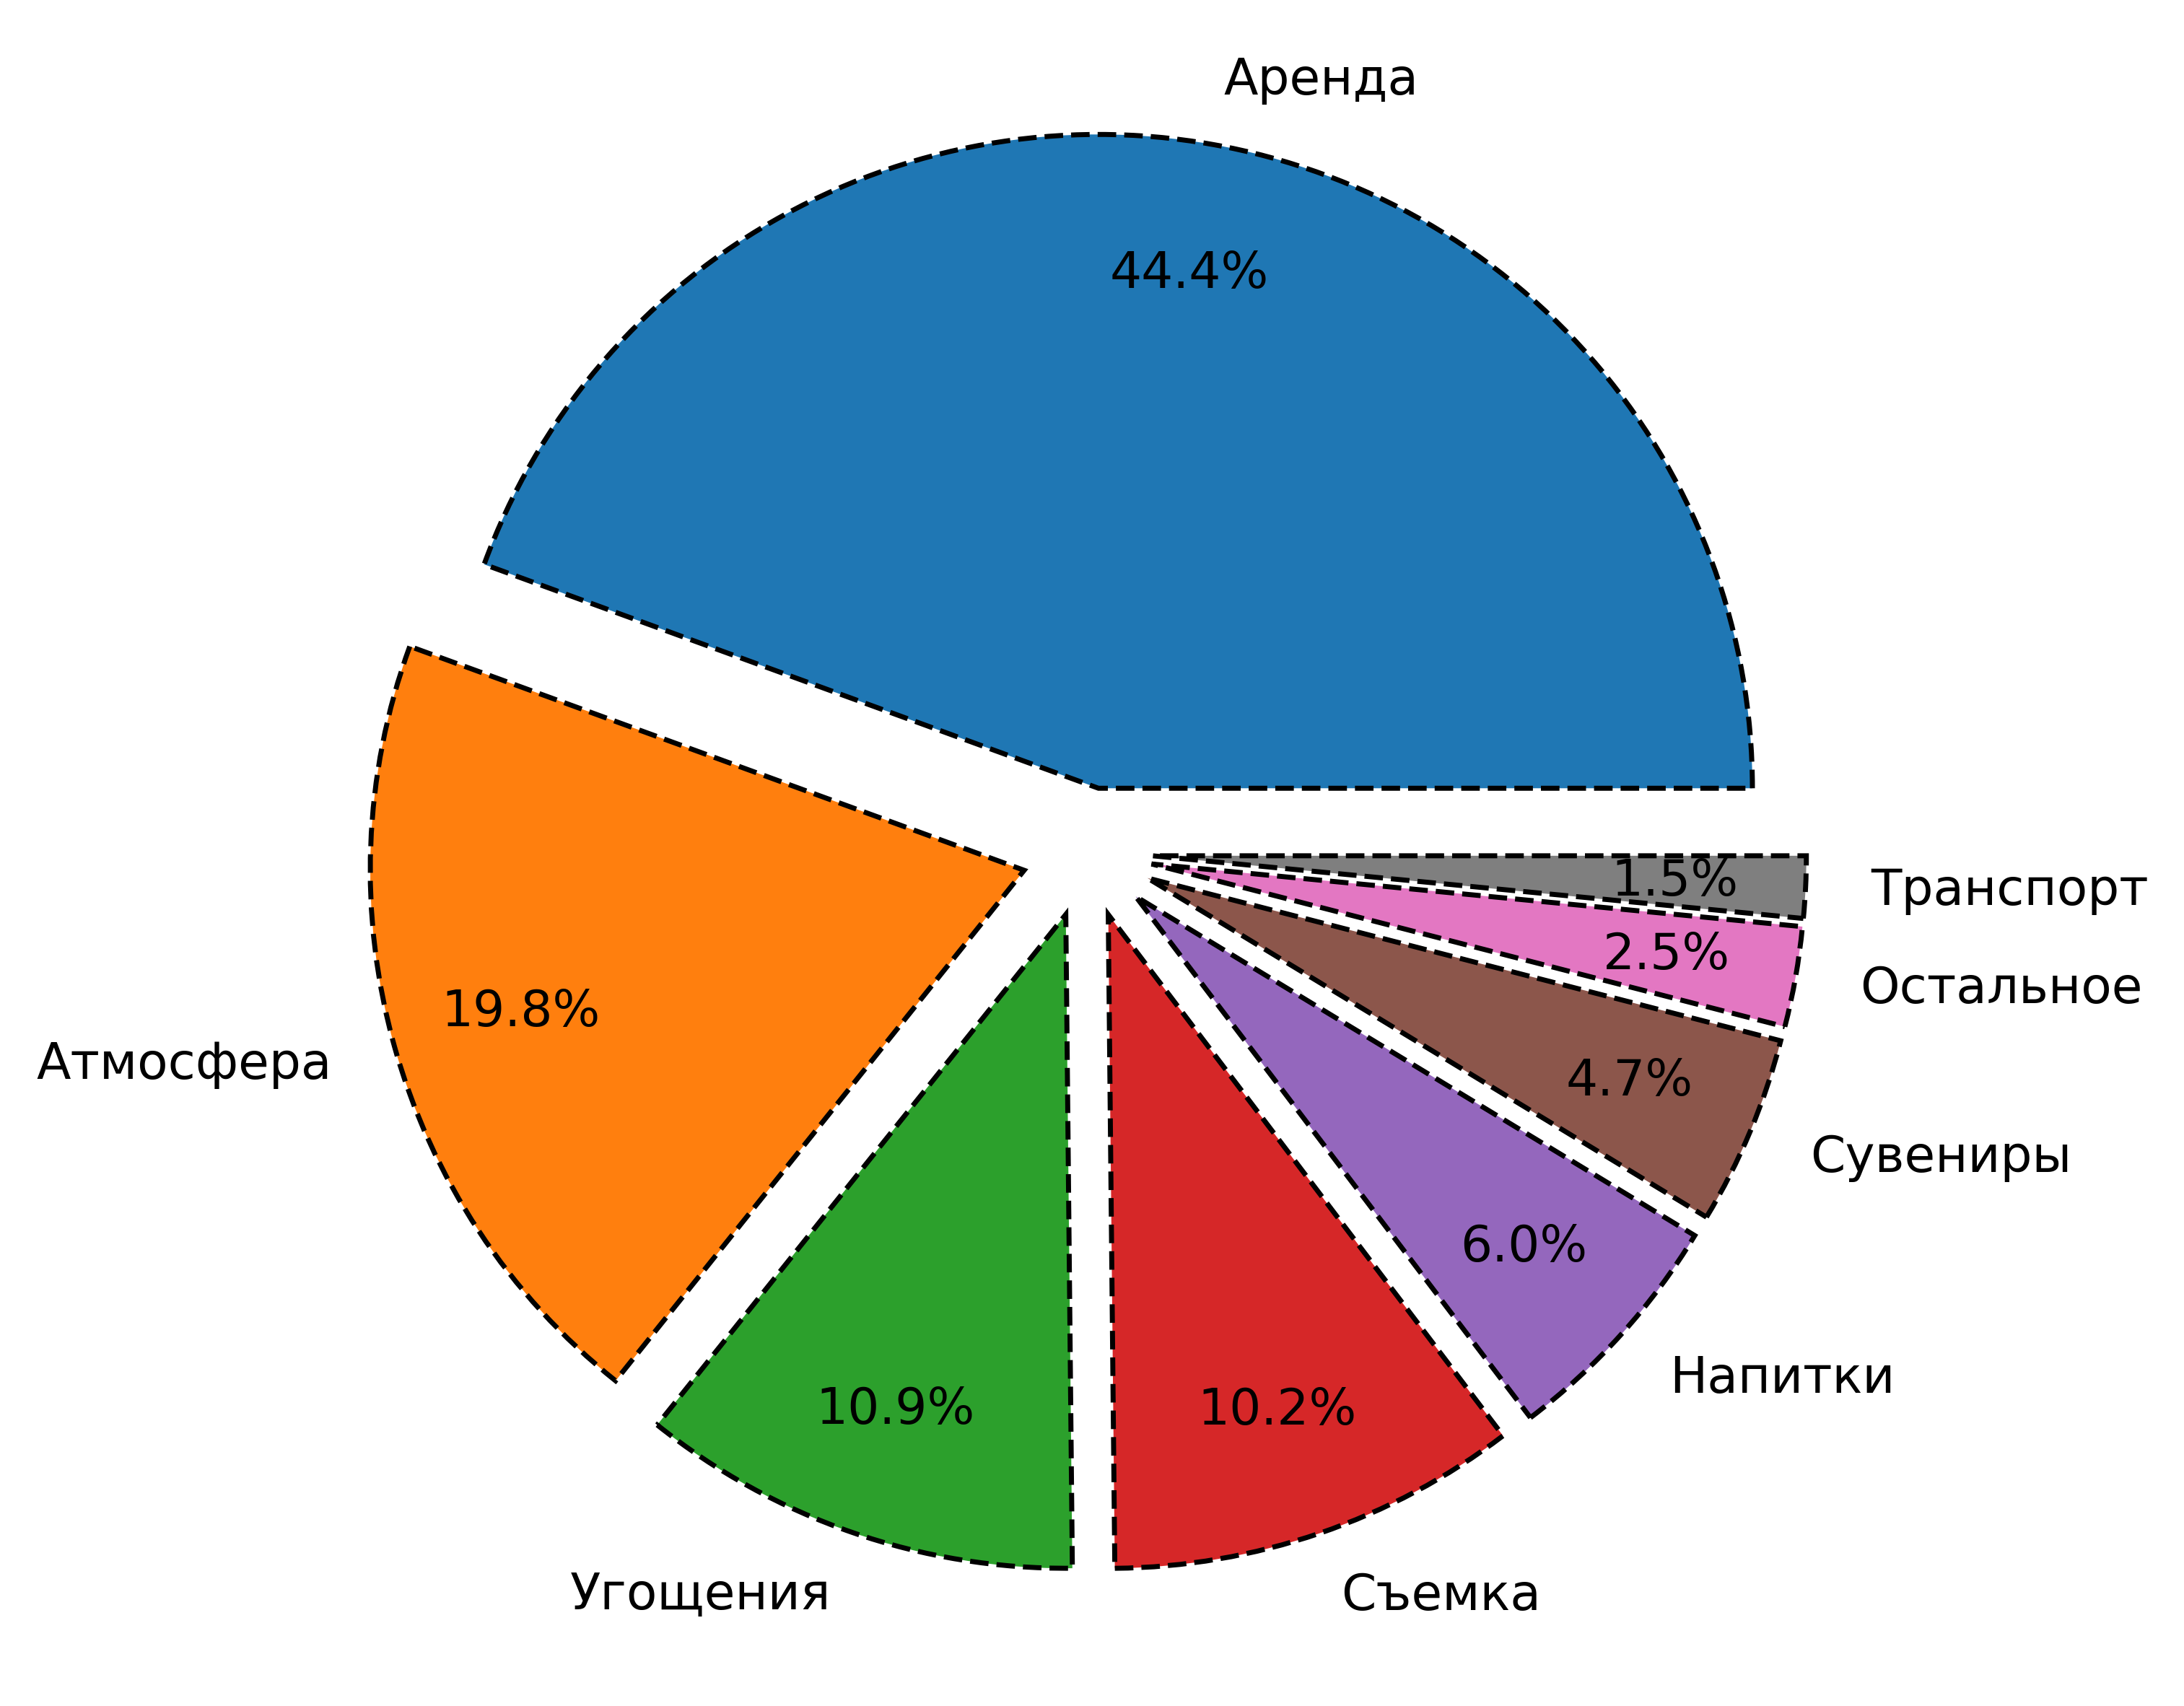

In [88]:
prod_profit_copy_2 = prod_profit_copy[prod_profit_copy['Product'] != 'Праздник']
plt.figure(figsize=(12,6), dpi=500)
exp = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plt.pie(prod_profit_copy_2.Cost, labels=prod_profit_copy_2.Product, autopct='%1.1f%%', 
        explode=exp, pctdistance=0.8, wedgeprops={'lw':1, 'ls':'--', 'edgecolor':"k"})
plt.show()

### Какая часть стоимости праздника уходит актерам?

In [320]:
actors = df[['Date', 'Price', 'Salaries']]

In [321]:
def salary(x):
    x = x.split(' ')
    y = [int(x1) for x1 in x if x1.isdigit()]
    for i in range(len(x)):
        if '=' in x[i]:
            return None
    if 'ОСТАТОК' in x:
        return sum(y[:-1])
    else:
        return sum(y)

salary('Артем (ИП) 1800 авто: Саша 1200 ОСТАТОК 100')

3000

In [322]:
actors['Sum'] = actors.Salaries.apply(salary)
actors['Percent'] = round(100 * actors.Sum / actors.Price, 1)

In [323]:
round(np.mean(actors.Percent), 1)

14.8

In [324]:
actors.dropna(inplace=True)
actors.drop([120,443], axis=0, inplace=True)
actors.sort_values('Percent', ascending=False).head(20)

,Date,Price,Salaries,Sum,Percent
204,2021-03-06,22420.0,Основной: Саша Савина 2550 Доп: Оля Ламонова 1...,12050.0,53.7
260,2021-02-25,18810.0,Ведущий: Дима 2550 Доп: Настя 1500 Координатор...,8550.0,45.5
334,2021-02-14,23465.0,Основной: Матвей 3300 Доп: Дима 1500 Координат...,9312.0,39.7
261,2021-02-25,22325.0,Артём 2550 (ИП) Кирилл 1500 Наташа Егорова 100...,8567.0,38.4
321,2021-02-16,65100.0,Артем (ИП) 2250+ 2000 (Тесла) + 750 (мафия дет...,22502.0,34.6
327,2021-02-14,48870.0,Основной: Раиса 2250 (самозанятость) Основной:...,15400.0,31.5
530,2021-01-13,24700.0,Ведущий: Артём 3000 (ИП) Доп: Дима 1200 Коорди...,7616.0,30.8
487,2021-01-23,17195.0,Основной: Иван 2250 Доп: Петя 1200 Координатор...,5150.0,30.0
373,2021-02-08,26270.0,Наташа 1800 Сергей 1200 Раиса 4000 (шоу),7000.0,26.6
304,2021-02-19,28690.0,Координатор: Аня 700 (самозанятость) Ведущий: ...,7572.0,26.4


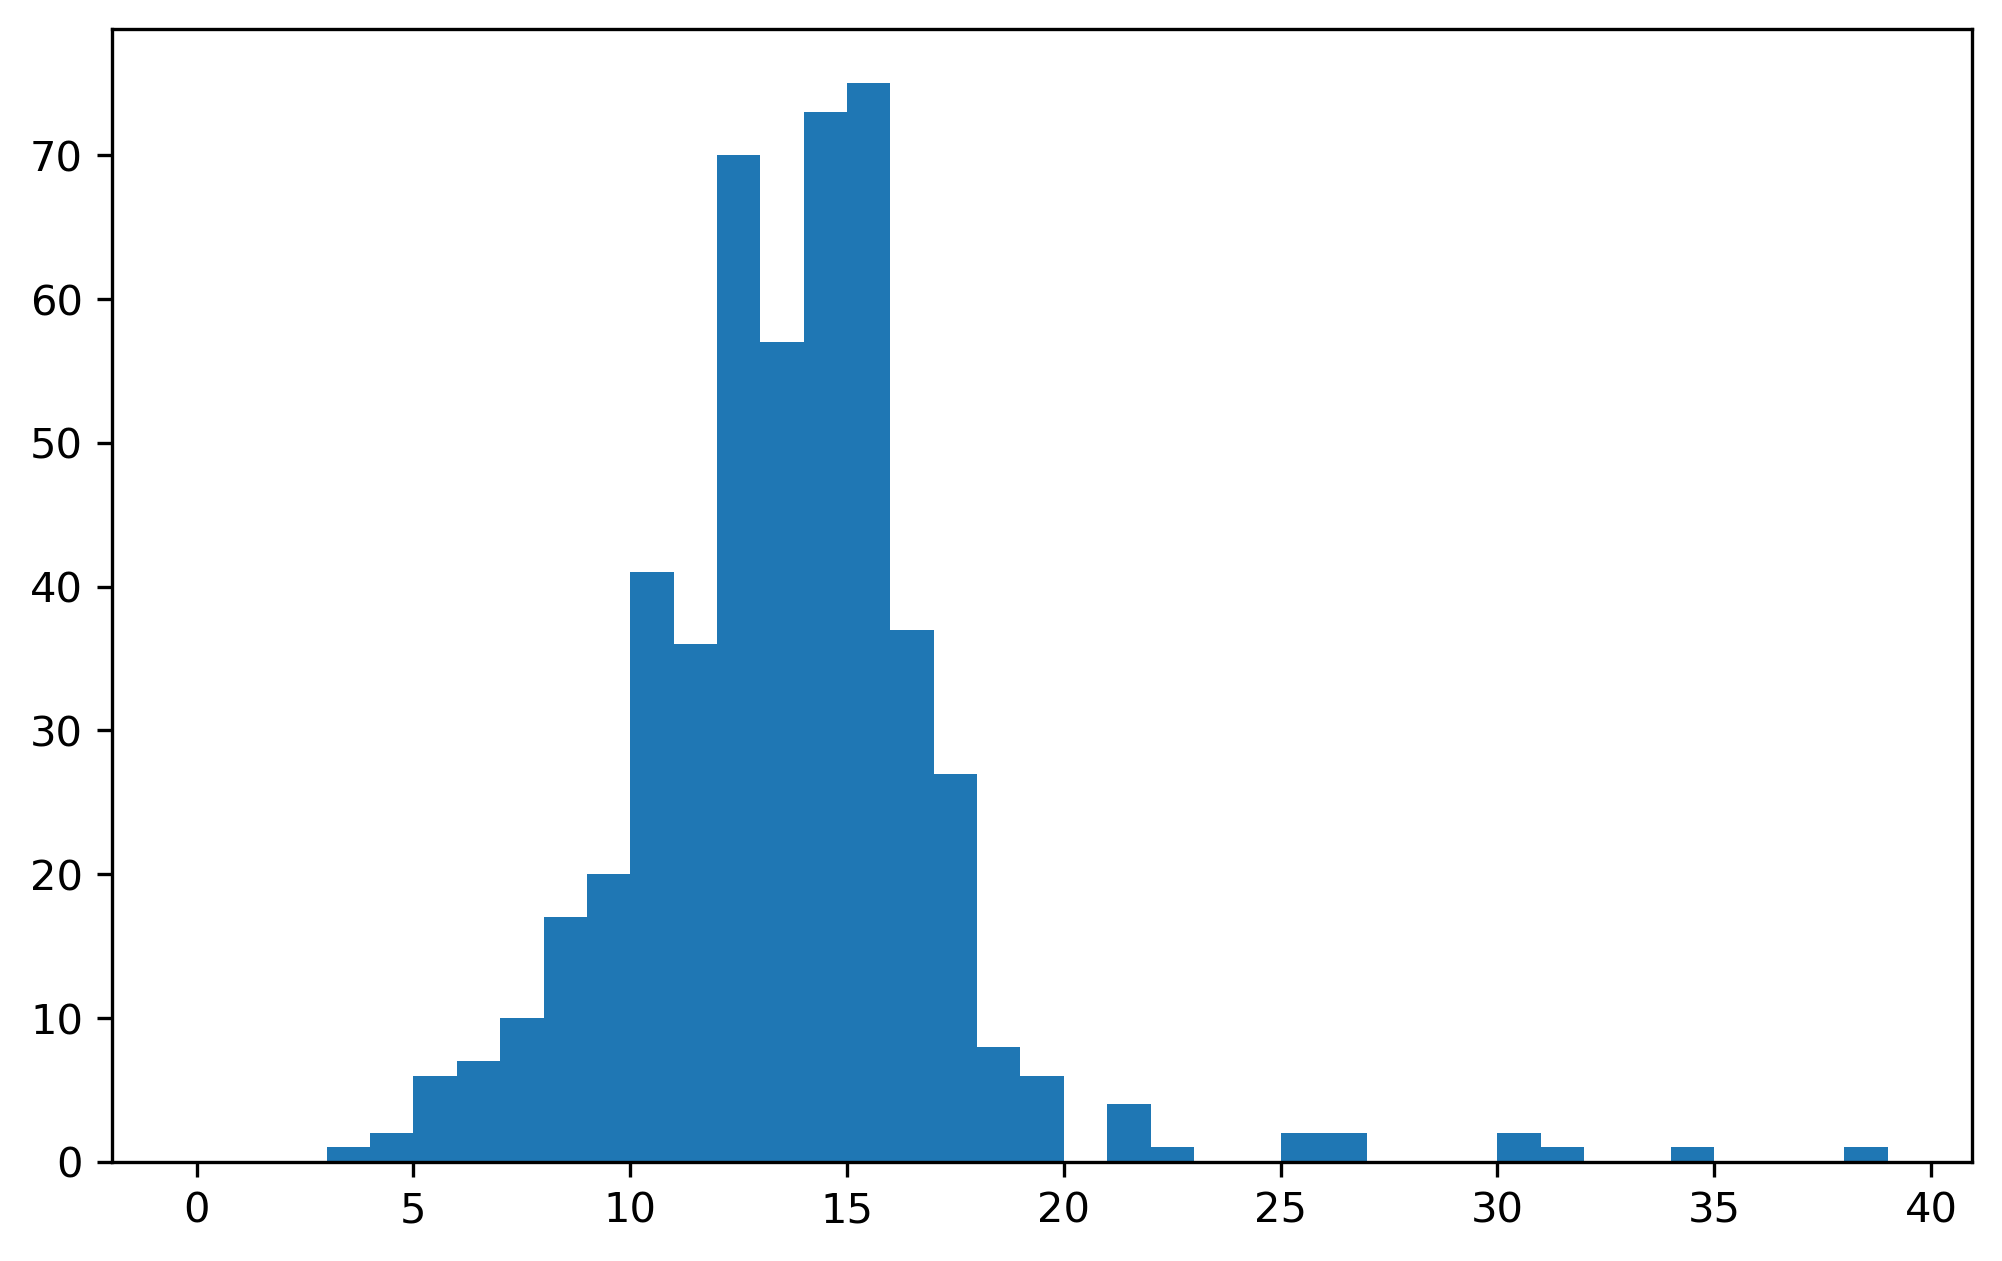

In [325]:
one = np.arange(0,40,1)

plt.figure(figsize=(8,5), dpi=300)
plt.hist(actors['Percent'], bins=one)
plt.show()

In [326]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

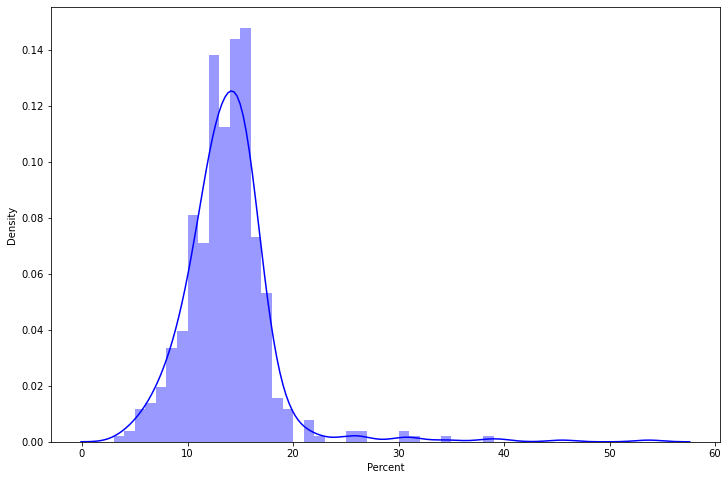

In [332]:
sns_plot = sns.distplot(actors['Percent'], bins=np.arange(0,40,1), color='blue')
fig = sns_plot.get_figure()